
# Black Carbon Cross-Method Analysis with Smoothing Techniques
  
This notebook extends the original cross-method analysis by applying three different smoothing techniques to the Aethalometer data before comparison with FTIR and HIPS measurements:
  
1. **Optimized Noise-reduction Algorithm (ONA)**: Adaptive time-averaging based on incremental light attenuation (ΔATN)
2. **Centered Moving Average (CMA)**: Fixed window smoothing that incorporates data points before and after each measurement
3. **Double Exponentially Weighted Moving Average (DEMA)**: Weighted smoothing that reduces noise while limiting lag

Note: All Aethalometer BC data is converted from ng/m³ to μg/m³ at load time to match FTIR and HIPS units.

## Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os
from matplotlib.ticker import ScalarFormatter
from datetime import timedelta
from scipy.stats import pearsonr
import numba  # Required for ONA algorithm

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)


## Step 1: Data Loading Functions
 
These functions handle loading and preparing data from the Aethalometer, HIPS, and FTIR sources.


In [2]:
def load_aethalometer_data(file_path, convert_to_ug=True):
    """
    Load and prepare Aethalometer data.
    
    Parameters:
    -----------
    file_path : str
        Path to the Aethalometer data file
    convert_to_ug : bool, default=True
        If True, converts BC values from ng/m³ to μg/m³
    """
    print(f"Loading Aethalometer data from: {file_path}")
    
    try:
        # Try to use polars for faster loading if available
        try:
            import polars as pl
            print("Using Polars for data loading (faster)")
            pl_data = pl.read_csv(file_path)
            df = pl_data.to_pandas()
        except ImportError:
            print("Polars not available, using pandas")
            df = pd.read_csv(file_path)
        
        # Parse date and time columns if they exist
        datetime_col = None
        if 'Date local (yyyy/MM/dd)' in df.columns and 'Time local (hh:mm:ss)' in df.columns:
            # Try multiple formats to handle different date formats
            try:
                formats_to_try = [
                    '%Y-%m-%d %I:%M:%S %p',  # 2022-04-12 9:46:01 AM
                    '%Y/%m/%d %H:%M:%S',     # 2022/04/12 09:46:01
                    '%Y-%m-%d %H:%M:%S'      # 2022-04-12 09:46:01
                ]
                
                for fmt in formats_to_try:
                    try:
                        df['datetime_local'] = pd.to_datetime(
                            df['Date local (yyyy/MM/dd)'] + ' ' + df['Time local (hh:mm:ss)'],
                            format=fmt
                        )
                        datetime_col = 'datetime_local'
                        print(f"Successfully parsed dates with format: {fmt}")
                        break
                    except ValueError:
                        continue
                
                if datetime_col is None:
                    # If all specific formats fail, try the flexible approach
                    df['datetime_local'] = pd.to_datetime(
                        df['Date local (yyyy/MM/dd)'] + ' ' + df['Time local (hh:mm:ss)'],
                        format='mixed'
                    )
                    datetime_col = 'datetime_local'
                    print("Parsed dates using flexible 'mixed' format")
            except Exception as e:
                print(f"Error parsing date/time: {e}")
                print("Sample date values:", df['Date local (yyyy/MM/dd)'].iloc[:5].tolist())
                print("Sample time values:", df['Time local (hh:mm:ss)'].iloc[:5].tolist())
                return None
        elif 'datetime_local' in df.columns:
            # Column already exists
            df['datetime_local'] = pd.to_datetime(df['datetime_local'])
            datetime_col = 'datetime_local'
        
        # Set index if datetime column is found
        if datetime_col:
            df.set_index(datetime_col, inplace=True)
            df.index = df.index.floor('min')  # Ensure clean 1-min resolution
            df.sort_index(inplace=True)
        else:
            print("ERROR: No valid datetime column found")
            return None
        
        print(f"Loaded {len(df):,} Aethalometer records spanning {df.index.min()} to {df.index.max()}")
        
        # Check if Red BCc column exists
        if 'Red BCc' in df.columns:
            print(f"Red BCc data available: {df['Red BCc'].describe().round(2)}")
        else:
            print("WARNING: 'Red BCc' column not found in the dataset!")
            print("Available columns:", df.columns.tolist())
            
        # Convert BC values from ng/m³ to μg/m³ if requested
        if convert_to_ug:
            # Find all BC columns (both BCc and BC variants)
            bc_columns = [col for col in df.columns if 'BC' in col]
            
            if bc_columns:
                print(f"\nConverting {len(bc_columns)} BC columns from ng/m³ to μg/m³:")
                for col in bc_columns:
                    # Store original range for reporting
                    orig_min = df[col].min()
                    orig_max = df[col].max()
                    
                    # Convert units
                    df[col] = df[col] / 1000
                    
                    print(f"  - {col}: Range changed from [{orig_min:.2f} - {orig_max:.2f}] ng/m³ to " +
                          f"[{df[col].min():.4f} - {df[col].max():.4f}] μg/m³")
            else:
                print("No BC columns found for unit conversion")
        
        return df
    
    except Exception as e:
        print(f"Error loading Aethalometer data: {e}")
        return None

In [3]:
def load_filter_sample_data(db_path):
    """Load ETAD (HIPS) and FTIR data from SQLite database."""
    print(f"Loading ETAD (HIPS) and FTIR filter sample data from: {db_path}")
    
    try:
        # Connect to the database
        conn = sqlite3.connect(db_path)
        
        # Load HIPS/FTIR data for the ETAD site
        query = """
        SELECT f.filter_id, 
               f.sample_date AS SampleDate, 
               m.ec_ftir AS EC_FTIR,
               m.oc_ftir AS OC_FTIR,
               m.fabs AS Fabs,
               f.site_code AS Site
        FROM filters f
        JOIN ftir_sample_measurements m USING(filter_id)
        WHERE f.site_code = 'ETAD'
        ORDER BY f.sample_date;
        """
        
        # Execute the query and load into a DataFrame
        combined_data = pd.read_sql_query(query, conn)
        
        # Convert date column to datetime
        combined_data['SampleDate'] = pd.to_datetime(combined_data['SampleDate'])
        
        # For compatibility with existing code, create separate dataframes for HIPS and FTIR
        # Both dataframes contain the same data since they're joined in the database
        etad_data = combined_data.copy()
        ftir_data = combined_data.copy()
        ftir_data.rename(columns={'SampleDate': 'date'}, inplace=True)
        
        # Display summary
        valid_samples_count = etad_data['SampleDate'].notna().sum()
        
        print(f"Loaded {len(etad_data)} ETAD samples from database ({valid_samples_count} with valid dates)")
        print(f"  - All samples have both HIPS and FTIR measurements")
        
        # Close the connection
        conn.close()
        
        return etad_data, ftir_data
    
    except Exception as e:
        print(f"Error loading filter sample data: {e}")
        print("Will attempt to create empty dataframes as fallback...")
        etad_data = pd.DataFrame(columns=['filter_id', 'SampleDate', 'Fabs', 'Site'])
        ftir_data = pd.DataFrame(columns=['filter_id', 'date', 'EC_FTIR', 'OC_FTIR'])
        return etad_data, ftir_data


## Step 2: Data Processing Functions
 
These functions identify 'excellent' data quality periods and extract the overlapping measurements.


In [4]:
def identify_excellent_periods(aethalometer_df, quality_df=None):
    """
    Identify excellent 9am-to-9am periods directly from Aethalometer data
    or from a pre-computed quality classification DataFrame.
    """
    if quality_df is not None and 'aethalometer_quality' in quality_df.columns:
        print("Using pre-computed quality classifications")
        
        # Extract excellent periods
        excellent_periods = quality_df[quality_df['aethalometer_quality'] == 'Excellent']
        print(f"Found {len(excellent_periods)} excellent periods in quality classifications")
        
        return excellent_periods
    
    print("Computing excellent periods from scratch")
    
    # Start and end timestamps
    start, end = aethalometer_df.index.min(), aethalometer_df.index.max()
    
    # Create expected full timeline
    expected_idx = pd.date_range(start, end, freq='min')
    
    # Identify missing timestamps
    actual_idx = aethalometer_df.index.unique().sort_values()
    missing_idx = expected_idx.difference(actual_idx)
    
    # Create 9am-to-9am periods (matching filter sampling)
    # Shift each timestamp to the previous 9am boundary
    nine_am_periods = missing_idx.map(lambda ts: 
        ts.normalize() + pd.Timedelta(hours=9) if ts.hour < 9 
        else ts.normalize() + pd.Timedelta(hours=9) + pd.Timedelta(days=1)
    )
    
    # Count missing minutes per 9am-to-9am period
    missing_per_period = pd.Series(1, index=nine_am_periods).groupby(level=0).count()
    
    # Classify excellent periods (≤10 minutes missing)
    excellent_periods_idx = missing_per_period[missing_per_period <= 10].index
    
    # Create a DataFrame with the excellent periods
    excellent_periods = pd.DataFrame(index=excellent_periods_idx)
    excellent_periods['start_time'] = excellent_periods.index
    excellent_periods['end_time'] = excellent_periods['start_time'] + pd.Timedelta(days=1)
    excellent_periods['aethalometer_quality'] = 'Excellent'
    
    print(f"Computed {len(excellent_periods)} excellent periods from scratch")
    
    return excellent_periods

In [5]:
def extract_daily_aethalometer_data(aethalometer_df, period_start, period_end, column='Red BCc'):
    """
    Extract and process Aethalometer data for a specific 24-hour period.
    Returns summary statistics for the period.
    """
    try:
        # Extract data for the specific period
        period_data = aethalometer_df.loc[period_start:period_end, column].dropna()
        
        if len(period_data) == 0:
            return None
        
        # Calculate statistics
        stats = {
            'period_start': period_start,
            'period_end': period_end,
            'count': len(period_data),
            'mean': period_data.mean(),
            'median': period_data.median(),
            'min': period_data.min(),
            'max': period_data.max(),
            'std': period_data.std(),
            '25th': period_data.quantile(0.25),
            '75th': period_data.quantile(0.75),
            'negative_count': (period_data < 0).sum(),
            'negative_percent': (period_data < 0).mean() * 100
        }
        
        return stats
    except Exception as e:
        print(f"Error extracting data for period {period_start} to {period_end}: {e}")
        return None


In [6]:
def find_overlapping_excellent_data(aethalometer_df, filter_df, excellent_periods):
    """
    Find days with overlapping excellent Aethalometer data and filter samples.
    Returns a DataFrame with the overlapping periods.
    """
    print("\nFinding overlapping excellent periods with filter samples...")
    
    # Print debug info
    print(f"Filter DataFrame columns: {filter_df.columns.tolist()}")
    print(f"Excellent periods columns: {excellent_periods.columns.tolist()}")
    
    # Check if required columns exist
    if 'SampleDate' not in filter_df.columns:
        print("ERROR: SampleDate column not found in filter_df")
        return None
    
    if 'start_time' not in excellent_periods.columns:
        print("ERROR: start_time column not found in excellent_periods")
        return None
    
    # Convert filter sample dates to 9am start time format (24h earlier than collection)
    filter_dates = filter_df['SampleDate'].dropna()
    print(f"Filter dates range: {filter_dates.min()} to {filter_dates.max()}")
    print(f"Total filter dates: {len(filter_dates)}")
    
    # Print a few sample filter dates to debug
    print("Sample filter dates (first 5):")
    for date in filter_dates.head(5):
        print(f"  - {date}")
    
    # Convert to 9am start time (24h earlier than collection)
    filter_periods = pd.DatetimeIndex([
        d.normalize() + pd.Timedelta(hours=9) 
        for d in filter_dates
    ])
    
    # Get excellent period start times
    excellent_starts = excellent_periods['start_time']
    print(f"Excellent periods range: {excellent_starts.min()} to {excellent_starts.max()}")
    print(f"Total excellent periods: {len(excellent_starts)}")
    
    # Print a few sample excellent periods to debug
    print("Sample excellent period start times (first 5):")
    for date in excellent_starts.head(5):
        print(f"  - {date}")
    
    # Find overlap
    overlap_periods = pd.DatetimeIndex(filter_periods).intersection(excellent_starts)
    
    print(f"Found {len(overlap_periods)} overlapping excellent periods with filter samples")
    
    if len(overlap_periods) == 0:
        print("No overlapping periods found - cannot proceed with comparison.")
        return None
    
    # Print a few sample overlap periods to debug
    print("Sample overlap periods (first 5):")
    for date in overlap_periods[:5]:
        print(f"  - {date}")
    
    # Create DataFrame with the overlapping periods
    overlap_df = pd.DataFrame(index=overlap_periods)
    overlap_df['start_time'] = overlap_df.index
    overlap_df['end_time'] = overlap_df['start_time'] + pd.Timedelta(days=1)
    
    # Add filter sample data
    # Map each 9am start time back to the filter collection date (24h later)
    filter_collection_dates = overlap_df['start_time'] + pd.Timedelta(days=1)
    
    # Match with filter data - with more debugging and flexible matching
    print("Adding filter data to overlap DataFrame...")
    filter_columns_added = False
    matches_found = 0
    
    for i, row in overlap_df.iterrows():
        # Get the filter collection date (24h after start time)
        collection_date = row['start_time'] + pd.Timedelta(days=1)
        
        # Try exact datetime match first
        matching_sample = filter_df[filter_df['SampleDate'] == collection_date]
        
        # If no exact match, try matching only the date part (ignoring time)
        if len(matching_sample) == 0:
            # Convert collection_date to date-only for comparison
            collection_date_only = collection_date.date()
            # Convert filter_df SampleDate to date-only for comparison
            matching_sample = filter_df[filter_df['SampleDate'].dt.date == collection_date_only]
            
            if len(matching_sample) > 0:
                print(f"Found date-only match for {collection_date} -> {matching_sample['SampleDate'].iloc[0]}")
        
        if len(matching_sample) > 0:
            matches_found += 1
            
            # Add filter data to the overlap DataFrame
            try:
                overlap_df.loc[i, 'filter_id'] = matching_sample['filter_id'].iloc[0]
                overlap_df.loc[i, 'EC_FTIR'] = matching_sample['EC_FTIR'].iloc[0]
                overlap_df.loc[i, 'Fabs'] = matching_sample['Fabs'].iloc[0]
                filter_columns_added = True
            except Exception as e:
                print(f"Error adding filter data for {collection_date}: {e}")
            
            # Process Aethalometer data for this period
            period_end = row['end_time']
            aeth_stats = extract_daily_aethalometer_data(aethalometer_df, row['start_time'], period_end)
            
            if aeth_stats:
                for key, value in aeth_stats.items():
                    if key not in ['period_start', 'period_end']:
                        overlap_df.loc[i, f'aeth_{key}'] = value
    
    print(f"Matched {matches_found} out of {len(overlap_df)} overlap periods with filter data")
    
    # Check if we successfully added any data
    if not filter_columns_added:
        print("WARNING: No filter data was added to the overlap DataFrame")
        print("This could be due to a mismatch in dates or missing columns")
        
        # Attempt a more lenient approach - match filter collection dates to the day before excellent periods
        print("\nAttempting alternative date matching approach...")
        
        # Create a set of all filter collection dates (date only, no time)
        filter_dates_set = set(date.date() for date in filter_df['SampleDate'] if not pd.isna(date))
        
        # Create a new DataFrame to store matches
        new_overlap_df = pd.DataFrame()
        
        # For each filter date, find the corresponding excellent period
        matches = 0
        for collection_date in filter_dates_set:
            # Convert to datetime for easier manipulation
            collection_dt = pd.Timestamp(collection_date)
            
            # Find the excellent period that started 24h before this collection date
            start_time = collection_dt.normalize() + pd.Timedelta(hours=9) - pd.Timedelta(days=1)
            
            # Check if this start time is in excellent_periods
            if start_time in excellent_starts.values:
                matches += 1
                
                # Get filter data
                matching_filter = filter_df[filter_df['SampleDate'].dt.date == collection_date]
                
                if len(matching_filter) > 0:
                    # Create a new row for this match
                    new_row = pd.DataFrame({
                        'start_time': [start_time],
                        'end_time': [start_time + pd.Timedelta(days=1)],
                        'filter_id': [matching_filter['filter_id'].iloc[0]],
                        'EC_FTIR': [matching_filter['EC_FTIR'].iloc[0]],
                        'Fabs': [matching_filter['Fabs'].iloc[0]]
                    })
                    
                    # Add Aethalometer data
                    aeth_stats = extract_daily_aethalometer_data(
                        aethalometer_df, start_time, start_time + pd.Timedelta(days=1)
                    )
                    
                    if aeth_stats:
                        for key, value in aeth_stats.items():
                            if key not in ['period_start', 'period_end']:
                                new_row[f'aeth_{key}'] = value
                    
                    # Append to our new DataFrame
                    new_overlap_df = pd.concat([new_overlap_df, new_row], ignore_index=True)
        
        if matches > 0:
            print(f"Alternative approach found {matches} matches")
            if len(new_overlap_df) > 0:
                print(f"Successfully created alternate overlap DataFrame with {len(new_overlap_df)} rows")
                print(f"Columns: {new_overlap_df.columns.tolist()}")
                return new_overlap_df
    
    # Check which columns exist before dropping
    print(f"Overlap DataFrame columns: {overlap_df.columns.tolist()}")
    
    # Define required columns
    required_cols = ['filter_id', 'aeth_mean']
    missing_cols = [col for col in required_cols if col not in overlap_df.columns]
    
    if missing_cols:
        print(f"WARNING: Missing required columns: {missing_cols}")
        print("Keeping all rows for now")
    else:
        # Drop any rows without filter or Aethalometer data
        print("Dropping rows with missing filter or Aethalometer data...")
        orig_len = len(overlap_df)
        print(f"Dropped {orig_len - len(overlap_df)} incomplete rows")
    
    print(f"Final count of complete overlapping periods: {len(overlap_df)}")
    
    return overlap_df


## Step 3: Smoothing Algorithm Implementations
 
Here we implement the three smoothing algorithms to apply to Aethalometer data prior to comparison.


In [7]:
# Implementation of Optimized Noise-reduction Algorithm (ONA)

@numba.jit(nopython=True)
def _numba_nanmean(arr_slice):
    """
    Numba-compatible nanmean function.
    """
    finite_sum = 0.0
    finite_count = 0
    for x in arr_slice:
        if not np.isnan(x): # np.isnan is Numba compatible
            finite_sum += x
            finite_count += 1
    if finite_count == 0:
        return np.nan
    return finite_sum / finite_count

@numba.jit(nopython=True)
def process_ona_segment_numba_core(
    bc_col_np: np.ndarray,
    atn_col_np: np.ndarray,
    delta_atn_min: float,
    num_rows: int
):
    """
    Core ONA algorithm implemented for Numba.
    Operates on NumPy arrays for a single data segment.
    """
    # Initialize output arrays
    smoothed_col_np = bc_col_np.copy() # Start with original BC values
    points_col_np = np.ones(num_rows, dtype=np.int64) # Default points averaged is 1

    # If only one point (or none) in the segment, it's effectively averaged with itself.
    if num_rows <= 1:
        return smoothed_col_np, points_col_np

    j = 0 # Current starting index of the averaging window (0-based)
    while j < num_rows:
        cur_atn = atn_col_np[j]

        # Find the end of the window (exclusive index).
        # The window includes point j. All subsequent points k in the window
        # must satisfy: atn_col_np[k] <= cur_atn + delta_atn_min
        window_end_exclusive = j + 1
        while window_end_exclusive < num_rows:
            if atn_col_np[window_end_exclusive] > cur_atn + delta_atn_min:
                break # End of window found
            window_end_exclusive += 1
        
        # The current window for averaging is from index j to window_end_exclusive-1
        slice_bc_np = bc_col_np[j:window_end_exclusive]
        
        avg_bc = _numba_nanmean(slice_bc_np)
        num_points_in_window = window_end_exclusive - j # Length of the slice

        # Apply the averaged BC value and points count to all rows in the window
        for k_idx in range(j, window_end_exclusive):
            smoothed_col_np[k_idx] = avg_bc
            points_col_np[k_idx] = num_points_in_window
            
        # Move to the start of the next potential window
        j = window_end_exclusive
            
    return smoothed_col_np, points_col_np

def process_ona_segment_numba_wrapper(
    pdf: pd.DataFrame,
    bc_col: str,
    atn_col: str,
    points_col: str,
    smoothed_col: str,
    delta_atn_min: float
) -> pd.DataFrame:
    """
    Wrapper to run the ONA algorithm on one pandas segment using the Numba core.
    Returns the pandas DataFrame with updated points_col and smoothed_col columns.
    """
    # Initialize the columns with default values.
    if points_col not in pdf.columns:
        pdf[points_col] = 1
    else:
        pdf.loc[:, points_col] = 1 # Use .loc to avoid SettingWithCopyWarning

    if smoothed_col not in pdf.columns:
        pdf[smoothed_col] = pdf[bc_col].copy()
    else:
        pdf.loc[:, smoothed_col] = pdf[bc_col].copy()

    if len(pdf) <= 1:
        # If the segment is very short, ensure original values and 1 point averaged is returned
        pdf.loc[:, smoothed_col] = pdf[bc_col].copy()
        pdf.loc[:, points_col] = 1
        return pdf

    # Convert relevant pandas Series to NumPy arrays for Numba
    bc_col_np = pdf[bc_col].to_numpy(dtype=np.float64, na_value=np.nan)
    atn_col_np = pdf[atn_col].to_numpy(dtype=np.float64, na_value=np.nan)
    
    num_rows = len(pdf)

    # Call the Numba-optimized core function
    smoothed_result_np, points_result_np = process_ona_segment_numba_core(
        bc_col_np, atn_col_np, delta_atn_min, num_rows
    )

    # Assign results back to the pandas DataFrame using .loc to ensure modification
    pdf.loc[:, smoothed_col] = smoothed_result_np
    pdf.loc[:, points_col] = points_result_np
    
    return pdf

def apply_ona(data, wavelength="Red", delta_atn_min=0.05):
    """
    Apply the Optimized Noise-reduction Algorithm to Aethalometer data.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame with Aethalometer data
    wavelength : str
        Which wavelength to process ('UV', 'Blue', 'Green', 'Red', 'IR')
    delta_atn_min : float
        Minimum change in attenuation to define a window
        
    Returns:
    --------
    data_processed : pandas.DataFrame
        DataFrame with original data plus additional columns for ONA processed BC
    """
    # Column names
    bc_col = f"{wavelength} BCc"
    atn_col = f"{wavelength} ATN1"
    points_col = f"{wavelength}_points_averaged"
    smoothed_col = f"{wavelength}_BC_ONA"

    # Check if required columns exist
    if atn_col not in data.columns or bc_col not in data.columns:
        print(f"Warning: Required columns ({atn_col}, {bc_col}) not found for ONA on wavelength {wavelength}. Skipping ONA.")
        result_df = data.copy()
        if points_col not in result_df.columns:
            result_df[points_col] = 1
        if smoothed_col not in result_df.columns:
            if bc_col in result_df.columns:
                result_df[smoothed_col] = result_df[bc_col]
            else:
                result_df[smoothed_col] = np.nan
        return result_df

    # Create a copy to avoid modifying the original
    df = data.copy()
    
    # Calculate absolute ATN differences to identify filter changes
    df['ΔATN'] = df[atn_col].diff().abs()
    
    # A new segment starts if ΔATN > 30 OR if ΔATN is null (first row)
    df['segment_id'] = ((df['ΔATN'] > 30) | df['ΔATN'].isna()).astype(int).cumsum()
    
    actual_filter_changes = df[df['ΔATN'] > 30].shape[0]
    print(f"Number of actual filter changes (ΔATN > 30) detected for {wavelength}: {actual_filter_changes}")
    
    # Initialize output columns
    df[points_col] = 1
    df[smoothed_col] = df[bc_col].copy()
    
    # Process each segment
    segments = df.groupby('segment_id')
    processed_segments = []
    
    for seg_id, segment in segments:
        # Sort by index within segment to ensure time order
        segment = segment.sort_index()
        
        # Process the segment
        processed_segment = process_ona_segment_numba_wrapper(
            segment, bc_col, atn_col, points_col, smoothed_col, delta_atn_min
        )
        
        processed_segments.append(processed_segment)
    
    # Combine processed segments
    if processed_segments:
        result_df = pd.concat(processed_segments)
        # Restore original sort order
        result_df = result_df.sort_index()
        
        # Drop temporary columns
        result_df = result_df.drop(['ΔATN', 'segment_id'], axis=1)
    else:
        # Fallback if no segments were processed
        result_df = df.drop(['ΔATN', 'segment_id'], axis=1)
    
    return result_df

# Implementation of Centered Moving Average (CMA)

In [8]:
def apply_cma(data, wavelength='Red', window_size=None):
    """
    Apply the Centered Moving Average algorithm to Aethalometer data
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame containing Aethalometer data
    wavelength : str
        Which wavelength to process ('UV', 'Blue', 'Green', 'Red', 'IR')
    window_size : int or None
        Size of the moving average window (must be odd). If None, 
        will use a default based on the data's timebase
        
    Returns:
    --------
    data_smoothed : pandas.DataFrame
        DataFrame with the original data plus additional columns for smoothed BC
    """
    # Create a copy of the input dataframe
    data_smoothed = data.copy()
    
    # Identify the column for BC values based on wavelength
    bc_col = f"{wavelength} BCc"
    smoothed_bc_col = f"{wavelength}_BC_CMA"
    
    # Determine window size if not specified
    if window_size is None:
        if 'Timebase (s)' in data_smoothed.columns:
            timebase = data_smoothed['Timebase (s)'].iloc[0]
            if timebase == 1:
                window_size = 11  # 11 seconds for 1-second data
            elif timebase == 5:
                window_size = 5   # 25 seconds for 5-second data
            elif timebase == 60:
                window_size = 3   # 3 minutes for 1-minute data
            else:
                window_size = 5   # Default for other timebases
        else:
            window_size = 5       # Default if timebase is unknown
    
    # Make sure window_size is odd
    if window_size % 2 == 0:
        window_size += 1
    
    print(f"Using window size of {window_size} for CMA on {wavelength}")
    
    # Apply rolling mean with center=True
    if bc_col in data_smoothed.columns:
        data_smoothed[smoothed_bc_col] = data_smoothed[bc_col].rolling(
            window=window_size, center=True, min_periods=1
        ).mean()
    else:
        print(f"Warning: {bc_col} not found in data, cannot apply CMA")
        data_smoothed[smoothed_bc_col] = np.nan
    
    return data_smoothed


# Implementation of Double Exponentially Weighted Moving Average (DEMA)

In [9]:
def apply_dema(data, wavelength='Red', alpha=None):
    """
    Apply the Double Exponentially Weighted Moving Average algorithm
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame containing Aethalometer data
    wavelength : str
        Which wavelength to process ('UV', 'Blue', 'Green', 'Red', 'IR')
    alpha : float
        Smoothing parameter (between 0 and 1)
        For 60s data, 0.125 approximates a 15-minute smoothing window
        
    Returns:
    --------
    data_smoothed : pandas.DataFrame
        DataFrame with the original data plus additional columns for smoothed BC
    """
    # Create a copy of the input dataframe
    data_smoothed = data.copy()
    
    # Identify the column for BC values based on wavelength
    bc_col = f"{wavelength} BCc"
    ema_col = f"{wavelength}_EMA"
    dema_col = f"{wavelength}_BC_DEMA"
    
    # Set the smoothing parameter based on timebase if not explicitly provided
    if 'Timebase (s)' in data_smoothed.columns:
        timebase = data_smoothed['Timebase (s)'].iloc[0]
        if alpha is None:
            # Use formula 2/(N+1) where N is the desired smoothing period
            if timebase == 1:
                # Default to approximate 5-minute window for 1-second data
                N = 300 / timebase
            elif timebase == 5:
                # Default to approximate 5-minute window for 5-second data
                N = 300 / timebase
            elif timebase == 60:
                # Default to approximate 15-minute window for 60-second data
                N = 900 / timebase
            else:
                N = 15  # Default for other timebases
                
            alpha = 2 / (N + 1)
    else:
        # Default alpha if timebase is unknown
        if alpha is None:
            alpha = 0.125
    
    print(f"Using alpha of {alpha:.4f} for DEMA on {wavelength}")
    
    if bc_col in data_smoothed.columns:
        # First EMA calculation
        data_smoothed[ema_col] = data_smoothed[bc_col].ewm(alpha=alpha, adjust=False).mean()
        
        # Second EMA calculation (EMA of EMA)
        ema_of_ema = data_smoothed[ema_col].ewm(alpha=alpha, adjust=False).mean()
        
        # Calculate DEMA: (2 * EMA) - EMA(EMA)
        data_smoothed[dema_col] = 2 * data_smoothed[ema_col] - ema_of_ema
    else:
        print(f"Warning: {bc_col} not found in data, cannot apply DEMA")
        data_smoothed[ema_col] = np.nan
        data_smoothed[dema_col] = np.nan
    
    return data_smoothed

## Step 4: Function to Apply All Smoothing Methods

In [10]:
def apply_all_smoothing_methods(aethalometer_df, wavelength="Red"):
    """
    Apply all three smoothing methods to aethalometer data for a specific wavelength.
    
    Parameters:
    -----------
    aethalometer_df : pandas.DataFrame
        DataFrame with aethalometer data
    wavelength : str
        Wavelength to process ('UV', 'Blue', 'Green', 'Red', 'IR')
        
    Returns:
    --------
    smoothed_data : dict
        Dictionary with keys 'raw', 'ona', 'cma', 'dema' containing the processed dataframes
    """
    print(f"\nApplying smoothing methods to {wavelength} wavelength data...")
    
    # Raw data (unprocessed)
    raw_data = aethalometer_df.copy()
    
    # Apply ONA
    print(f"\nApplying ONA to {wavelength} wavelength data...")
    ona_data = apply_ona(aethalometer_df, wavelength)
    
    # Apply CMA
    print(f"\nApplying CMA to {wavelength} wavelength data...")
    cma_data = apply_cma(aethalometer_df, wavelength)
    
    # Apply DEMA
    print(f"\nApplying DEMA to {wavelength} wavelength data...")
    dema_data = apply_dema(aethalometer_df, wavelength)
    
    return {
        'raw': raw_data,
        'ona': ona_data,
        'cma': cma_data,
        'dema': dema_data
    }

In [11]:
def extract_smoothed_aethalometer_data(smoothed_data, method, period_start, period_end, wavelength="Red"):
    """
    Extract and process smoothed Aethalometer data for a specific 24-hour period.
    
    Parameters:
    -----------
    smoothed_data : dict
        Dictionary with keys 'raw', 'ona', 'cma', 'dema' containing the processed dataframes
    method : str
        Smoothing method ('raw', 'ona', 'cma', 'dema')
    period_start, period_end : datetime
        Start and end of the 24-hour period
    wavelength : str
        Wavelength to process ('UV', 'Blue', 'Green', 'Red', 'IR')
        
    Returns:
    --------
    stats : dict
        Dictionary with summary statistics for the period
    """
    # Select the column based on smoothing method
    if method == 'raw':
        column = f"{wavelength} BCc"
        df = smoothed_data['raw']
    elif method == 'ona':
        column = f"{wavelength}_BC_ONA"
        df = smoothed_data['ona']
    elif method == 'cma':
        column = f"{wavelength}_BC_CMA"
        df = smoothed_data['cma']
    elif method == 'dema':
        column = f"{wavelength}_BC_DEMA"
        df = smoothed_data['dema']
    else:
        print(f"Invalid method: {method}")
        return None
    
    try:
        # Extract data for the specific period
        period_data = df.loc[period_start:period_end, column].dropna()
        
        if len(period_data) == 0:
            return None
        
        # Calculate statistics
        stats = {
            'period_start': period_start,
            'period_end': period_end,
            'count': len(period_data),
            'mean': period_data.mean(),
            'median': period_data.median(),
            'min': period_data.min(),
            'max': period_data.max(),
            'std': period_data.std(),
            '25th': period_data.quantile(0.25),
            '75th': period_data.quantile(0.75),
            'negative_count': (period_data < 0).sum(),
            'negative_percent': (period_data < 0).mean() * 100
        }
        
        return stats
    except Exception as e:
        print(f"Error extracting {method} data for period {period_start} to {period_end}: {e}")
        return None


In [12]:
def create_overlap_df_with_all_methods(overlap_df_raw, smoothed_data, wavelength="Red"):
    """
    Add columns for all smoothing methods to the overlap DataFrame.
    Modified to work with filtered data and handle missing timestamps.
    """
    print("Creating overlap DataFrame with all smoothing methods...")
    print(f"Input overlap_df_raw shape: {overlap_df_raw.shape}")
    
    # Create a copy of the raw overlap DataFrame
    overlap_df_all = overlap_df_raw.copy()
    
    # Method column names
    method_columns = {
        'raw': f"{wavelength} BCc",
        'ona': f"{wavelength}_BC_ONA",
        'cma': f"{wavelength}_BC_CMA",
        'dema': f"{wavelength}_BC_DEMA"
    }
    
    method_display_names = {
        'raw': 'Raw',
        'ona': 'ONA',
        'cma': 'CMA',
        'dema': 'DEMA'
    }
    
    # Process each period for each method
    for i, row in overlap_df_all.iterrows():
        period_start = row['start_time']
        period_end = row['end_time']
        
        for method_key, method_col in method_columns.items():
            df = smoothed_data[method_key]
            
            # Skip if column doesn't exist
            if method_col not in df.columns:
                print(f"Warning: {method_col} not found in {method_key} data")
                continue
            
            try:
                # Use between_time for safer time-based filtering
                # This avoids exact timestamp matching issues
                period_data = df[df.index >= period_start]
                period_data = period_data[period_data.index < period_end][method_col].copy()
                
                if len(period_data) == 0:
                    print(f"Warning: No data found for period {period_start} to {period_end}")
                    continue
                
                # Calculate statistics
                prefix = 'aeth_' if method_key == 'raw' else f'{method_key}_'
                
                # Save all statistics
                overlap_df_all.loc[i, f'{prefix}count'] = len(period_data)
                overlap_df_all.loc[i, f'{prefix}mean'] = period_data.mean()
                overlap_df_all.loc[i, f'{prefix}median'] = period_data.median()
                overlap_df_all.loc[i, f'{prefix}min'] = period_data.min()
                overlap_df_all.loc[i, f'{prefix}max'] = period_data.max()
                overlap_df_all.loc[i, f'{prefix}std'] = period_data.std()
                overlap_df_all.loc[i, f'{prefix}25th'] = period_data.quantile(0.25)
                overlap_df_all.loc[i, f'{prefix}75th'] = period_data.quantile(0.75)
                overlap_df_all.loc[i, f'{prefix}negative_count'] = (period_data < 0).sum()
                overlap_df_all.loc[i, f'{prefix}negative_percent'] = (period_data < 0).mean() * 100
            except Exception as e:
                print(f"Error processing {method_key} data for period {period_start}: {e}")
                continue
    
    # Print a summary of what we've added
    print("\nStatistics added for each smoothing method:")
    for method_key, display_name in method_display_names.items():
        prefix = 'aeth_' if method_key == 'raw' else f'{method_key}_'
        if f'{prefix}mean' in overlap_df_all.columns:
            print(f"{display_name} ({method_key}) - Mean BC range: {overlap_df_all[f'{prefix}mean'].min():.1f} to {overlap_df_all[f'{prefix}mean'].max():.1f}")
    
    # Add mean differences between methods
    for method1 in ['raw', 'ona', 'cma', 'dema']:
        for method2 in ['raw', 'ona', 'cma', 'dema']:
            if method1 != method2:
                prefix1 = 'aeth_' if method1 == 'raw' else f'{method1}_'
                prefix2 = 'aeth_' if method2 == 'raw' else f'{method2}_'
                
                if f'{prefix1}mean' in overlap_df_all.columns and f'{prefix2}mean' in overlap_df_all.columns:
                    col_name = f'{method1}_vs_{method2}_diff_pct'
                    overlap_df_all[col_name] = (overlap_df_all[f'{prefix1}mean'] - overlap_df_all[f'{prefix2}mean']) / overlap_df_all[f'{prefix2}mean'] * 100
    
    print(f"Output overlap_df_all shape: {overlap_df_all.shape}")
    print(f"Column count: {len(overlap_df_all.columns)}")
    return overlap_df_all

## Step 6: Enhanced Visualization Functions for Comparison with Filter Data

In [13]:
def plot_bc_scatter_all_methods(overlap_df, y_param='EC_FTIR', wavelength="Red", title_prefix=None):
    """
    Create scatter plots comparing all smoothing methods with FTIR EC or HIPS Fabs.
    
    Parameters:
    -----------
    overlap_df : pandas.DataFrame
        DataFrame with overlapping periods including all smoothing methods
    y_param : str
        Filter parameter to compare against ('EC_FTIR' or 'Fabs')
    wavelength : str
        Wavelength used for BC data
    title_prefix : str or None
        Optional prefix for plot title
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        Figure with the plots
    """
    # Method column mappings
    method_columns = {
        'Raw': 'aeth_mean',
        'ONA': 'ona_mean',
        'CMA': 'cma_mean',
        'DEMA': 'dema_mean'
    }
    
    # Method colors and markers
    method_styles = {
        'Raw': {'color': 'black', 'marker': 'o', 'alpha': 0.5},
        'ONA': {'color': 'blue', 'marker': 's', 'alpha': 0.7},
        'CMA': {'color': 'red', 'marker': '^', 'alpha': 0.7},
        'DEMA': {'color': 'green', 'marker': 'D', 'alpha': 0.7}
    }
    
    # Parameter labels
    param_labels = {
        'EC_FTIR': 'FTIR EC (μg/m³)',
        'Fabs': 'HIPS Fabs'
    }
    
    # Create figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True, sharey=True)
    axes = axes.flatten()
    
    # Title for the figure
    if title_prefix is None:
        title_prefix = f"{wavelength} BCc vs"
    fig.suptitle(f"{title_prefix} {param_labels.get(y_param, y_param)}\nComparison of Smoothing Methods", fontsize=16)
    
    # Process each method
    regression_results = {}
    for i, (method_name, col_name) in enumerate(method_columns.items()):
        ax = axes[i]
        
        # Skip if column not available
        if col_name not in overlap_df.columns or y_param not in overlap_df.columns:
            ax.text(0.5, 0.5, f"Data not available for {method_name}", 
                    ha='center', va='center', transform=ax.transAxes)
            continue
        
        # Prepare data
        x = overlap_df[col_name]
        y = overlap_df[y_param]
        
        # Create scatter plot
        style = method_styles[method_name]
        scatter = ax.scatter(x, y, s=80, **style)
        
        # Calculate and add trendline
        mask = ~np.isnan(x) & ~np.isnan(y)
        if mask.sum() > 1:  # Need at least 2 valid points for regression
            slope, intercept = np.polyfit(x[mask], y[mask], 1)
            x_line = np.linspace(x.min(), x.max(), 100)
            y_line = slope * x_line + intercept
            ax.plot(x_line, y_line, 'r--', linewidth=2)
            
            # Add regression equation and R² to plot
            r_value = pearsonr(x[mask], y[mask])[0]
            r_squared = r_value**2
            
            equation = f"y = {slope:.3f}x + {intercept:.3f}"
            r2_text = f"R² = {r_squared:.3f}"
            
            ax.annotate(
                equation + '\n' + r2_text,
                xy=(0.05, 0.95),
                xycoords='axes fraction',
                fontsize=12,
                ha='left',
                va='top',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
            )
            
            # Store regression results
            regression_results[method_name] = {
                'slope': slope,
                'intercept': intercept,
                'r_squared': r_squared,
                'data_points': mask.sum()
            }
        
        # Format subplot
        ax.set_title(f"{method_name} Processing", fontsize=14)
        if i >= 2:  # Only add x-label to bottom row
            ax.set_xlabel(f'Aethalometer {wavelength} BC (μg/m³)', fontsize=12)
        if i % 2 == 0:  # Only add y-label to left column
            ax.set_ylabel(param_labels.get(y_param, y_param), fontsize=12)
        
        # Make sure axes start at 0 if all data is positive
        if x.min() >= 0 and y.min() >= 0:
            ax.set_xlim(left=0)
            ax.set_ylim(bottom=0)
        
        # Add grid
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Add 1:1 line if units are comparable
        if y_param == 'EC_FTIR':
            max_val = max(x.max(), y.max()) * 1.1
            ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, linewidth=1, label='1:1 Line')
            ax.legend()
    
    # Add a summary table in a text box
    if regression_results:
        table_text = "Regression Results:\n"
        table_text += "-" * 60 + "\n"
        table_text += f"{'Method':<10} {'Slope':<10} {'Intercept':<10} {'R²':<10} {'N':<10}\n"
        table_text += "-" * 60 + "\n"
        
        for method, results in regression_results.items():
            table_text += f"{method:<10} {results['slope']:<10.3f} {results['intercept']:<10.3f} "
            table_text += f"{results['r_squared']:<10.3f} {results['data_points']:<10}\n"
        
        fig.text(0.5, 0.01, table_text, ha='center', va='bottom', 
                fontsize=10, family='monospace', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.15)  # Adjust for suptitle and table
    
    return fig, regression_results

In [14]:
def plot_method_comparison_all_smoothing(overlap_df, wavelength="Red"):
    """
    Create a comprehensive comparison plot of all smoothing methods against both FTIR and HIPS.
    
    Parameters:
    -----------
    overlap_df : pandas.DataFrame
        DataFrame with overlapping periods including all smoothing methods
    wavelength : str
        Wavelength used for BC data
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        Figure with the plots
    """
    # Method column mappings
    method_columns = {
        'Raw': 'aeth_mean',
        'ONA': 'ona_mean',
        'CMA': 'cma_mean',
        'DEMA': 'dema_mean'
    }
    
    # Method colors and markers
    method_styles = {
        'Raw': {'color': 'black', 'marker': 'o', 'alpha': 0.5},
        'ONA': {'color': 'blue', 'marker': 's', 'alpha': 0.7},
        'CMA': {'color': 'red', 'marker': '^', 'alpha': 0.7},
        'DEMA': {'color': 'green', 'marker': 'D', 'alpha': 0.7}
    }
    
    # Create figure with 2 subplots (one for FTIR, one for HIPS)
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Plot titles
    axes[0].set_title(f"Comparison with FTIR EC\n({wavelength} Wavelength, {len(overlap_df)} periods)", fontsize=14)
    axes[1].set_title(f"Comparison with HIPS Fabs\n({wavelength} Wavelength, {len(overlap_df)} periods)", fontsize=14)
    
    # Process each method for FTIR EC (left plot)
    regression_results_ftir = {}
    for method_name, col_name in method_columns.items():
        if col_name in overlap_df.columns and 'EC_FTIR' in overlap_df.columns:
            # Prepare data
            x = overlap_df[col_name]
            y = overlap_df['EC_FTIR']
            
            # Create scatter plot
            style = method_styles[method_name]
            scatter = axes[0].scatter(x, y, s=80, label=method_name, **style)
            
            # Calculate and add trendline
            mask = ~np.isnan(x) & ~np.isnan(y)
            if mask.sum() > 1:  # Need at least 2 valid points for regression
                slope, intercept = np.polyfit(x[mask], y[mask], 1)
                x_line = np.linspace(x.min(), x.max(), 100)
                y_line = slope * x_line + intercept
                axes[0].plot(x_line, y_line, color=style['color'], linestyle='--', linewidth=2)
                
                # Store regression results
                r_value = pearsonr(x[mask], y[mask])[0]
                r_squared = r_value**2
                regression_results_ftir[method_name] = {
                    'slope': slope,
                    'intercept': intercept,
                    'r_squared': r_squared,
                    'data_points': mask.sum()
                }
    
    # Add 1:1 line to FTIR plot
    max_val_ftir = axes[0].get_xlim()[1]
    axes[0].plot([0, max_val_ftir], [0, max_val_ftir], 'k--', alpha=0.3, linewidth=1, label='1:1 Line')
    
    # Process each method for HIPS Fabs (right plot)
    regression_results_hips = {}
    for method_name, col_name in method_columns.items():
        if col_name in overlap_df.columns and 'Fabs' in overlap_df.columns:
            # Prepare data
            x = overlap_df[col_name]
            y = overlap_df['Fabs']
            
            # Create scatter plot
            style = method_styles[method_name]
            scatter = axes[1].scatter(x, y, s=80, label=method_name, **style)
            
            # Calculate and add trendline
            mask = ~np.isnan(x) & ~np.isnan(y)
            if mask.sum() > 1:  # Need at least 2 valid points for regression
                slope, intercept = np.polyfit(x[mask], y[mask], 1)
                x_line = np.linspace(x.min(), x.max(), 100)
                y_line = slope * x_line + intercept
                axes[1].plot(x_line, y_line, color=style['color'], linestyle='--', linewidth=2)
                
                # Store regression results
                r_value = pearsonr(x[mask], y[mask])[0]
                r_squared = r_value**2
                regression_results_hips[method_name] = {
                    'slope': slope,
                    'intercept': intercept,
                    'r_squared': r_squared,
                    'data_points': mask.sum()
                }
    
    # Format plots
    for i, ax in enumerate(axes):
        y_label = 'FTIR EC (μg/m³)' if i == 0 else 'HIPS Fabs'
        ax.set_xlabel(f'Aethalometer {wavelength} BC (μg/m³)', fontsize=12)
        ax.set_ylabel(y_label, fontsize=12)
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Make sure axes start at 0 if all data is positive
        ax.set_xlim(left=0)
        ax.set_ylim(bottom=0)
    
    # Add a summary table for each regression
    if regression_results_ftir or regression_results_hips:
        table_text = "Regression Results Summary:\n\n"
        
        # FTIR results
        if regression_results_ftir:
            table_text += "FTIR EC Comparison:\n"
            table_text += "-" * 60 + "\n"
            table_text += f"{'Method':<10} {'Slope':<10} {'Intercept':<10} {'R²':<10} {'N':<10}\n"
            table_text += "-" * 60 + "\n"
            
            for method, results in regression_results_ftir.items():
                table_text += f"{method:<10} {results['slope']:<10.3f} {results['intercept']:<10.3f} "
                table_text += f"{results['r_squared']:<10.3f} {results['data_points']:<10}\n"
        
        # HIPS results
        if regression_results_hips:
            if regression_results_ftir:
                table_text += "\n"
            table_text += "HIPS Fabs Comparison:\n"
            table_text += "-" * 60 + "\n"
            table_text += f"{'Method':<10} {'Slope':<10} {'Intercept':<10} {'R²':<10} {'N':<10}\n"
            table_text += "-" * 60 + "\n"
            
            for method, results in regression_results_hips.items():
                table_text += f"{method:<10} {results['slope']:<10.3f} {results['intercept']:<10.3f} "
                table_text += f"{results['r_squared']:<10.3f} {results['data_points']:<10}\n"
        
        fig.text(0.5, 0.01, table_text, ha='center', va='bottom', 
                fontsize=10, family='monospace', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)  # Adjust for table
    
    return fig, {'ftir': regression_results_ftir, 'hips': regression_results_hips}

In [15]:
def plot_seasonal_comparison_smoothed(overlap_df, smoothing_method, wavelength="Red"):
    """
    Create seasonal comparison plots for a specific smoothing method.
    
    Parameters:
    -----------
    overlap_df : pandas.DataFrame
        DataFrame with overlapping periods including all smoothing methods
    smoothing_method : str
        Smoothing method to plot ('raw', 'ona', 'cma', 'dema')
    wavelength : str
        Wavelength used for BC data
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        Figure with the plots
    """
    # Column mapping based on smoothing method
    method_column_map = {
        'raw': 'aeth_mean',
        'ona': 'ona_mean',
        'cma': 'cma_mean',
        'dema': 'dema_mean'
    }
    
    method_display_names = {
        'raw': 'Raw',
        'ona': 'ONA',
        'cma': 'CMA',
        'dema': 'DEMA'
    }
    
    # Get the correct column
    bc_col = method_column_map.get(smoothing_method.lower())
    if bc_col not in overlap_df.columns:
        print(f"Error: Column {bc_col} not found in overlap_df")
        return None
    
    # Add date and season information
    df = overlap_df.copy()
    if 'date' not in df.columns:
        df['date'] = df['start_time'].dt.date
    
    if 'month' not in df.columns:
        df['month'] = df['start_time'].dt.month
    
    # Map Ethiopian seasons
    def map_ethiopian_seasons(month):
        """Maps month number to Ethiopian season name."""
        if month in [10, 11, 12, 1, 2]:
            return 'Dry Season'
        elif month in [3, 4, 5]:
            return 'Belg Rainy Season'
        else:  # months 6–9
            return 'Kiremt Rainy Season'
    
    df['season'] = df['month'].apply(map_ethiopian_seasons)
    
    df['bc_ug'] = df[bc_col]
    
    # Define colors for seasons
    season_colors = {
        'Dry Season': 'gold',
        'Belg Rainy Season': 'limegreen',
        'Kiremt Rainy Season': 'royalblue'
    }
    
    # Create figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Plot 1: BC vs EC_FTIR by season
    ax1 = axes[0]
    
    # Separate scatter plots for each season
    for season, color in season_colors.items():
        season_data = df[df['season'] == season]
        if len(season_data) > 0:
            ax1.scatter(
                season_data['bc_ug'], 
                season_data['EC_FTIR'],
                alpha=0.7, 
                s=80, 
                c=color, 
                edgecolor='black',
                label=f"{season} (n={len(season_data)})"
            )
    
    # Overall trendline
    mask1 = ~np.isnan(df['bc_ug']) & ~np.isnan(df['EC_FTIR'])
    
    if mask1.sum() > 1:
        slope1, intercept1 = np.polyfit(df.loc[mask1, 'bc_ug'], df.loc[mask1, 'EC_FTIR'], 1)
        x_line1 = np.linspace(df['bc_ug'].min(), df['bc_ug'].max(), 100)
        y_line1 = slope1 * x_line1 + intercept1
        ax1.plot(x_line1, y_line1, 'r--', linewidth=2, label='All Seasons Fit')
        
        # Add regression equation and R²
        r_value1 = pearsonr(df.loc[mask1, 'bc_ug'], df.loc[mask1, 'EC_FTIR'])[0]
        r_squared1 = r_value1**2
        
        equation1 = f"y = {slope1:.3f}x + {intercept1:.3f}"
        r2_text1 = f"R² = {r_squared1:.3f}"
        
        ax1.annotate(
            equation1 + '\n' + r2_text1,
            xy=(0.05, 0.95),
            xycoords='axes fraction',
            fontsize=12,
            ha='left',
            va='top',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
        )
    
    # Format plot 1
    ax1.set_xlabel(f'Aethalometer {wavelength} BC (μg/m³) - {method_display_names[smoothing_method.lower()]}', fontsize=12)
    ax1.set_ylabel('FTIR EC (μg/m³)', fontsize=12)
    ax1.set_title(f"{wavelength} BC ({method_display_names[smoothing_method.lower()]}) vs FTIR EC by Ethiopian Season\n({mask1.sum()} samples)", fontsize=14)
    
    # Add 1:1 line
    max_val1 = max(df['bc_ug'].max(), df['EC_FTIR'].max()) * 1.1
    ax1.plot([0, max_val1], [0, max_val1], 'k--', alpha=0.3, linewidth=1, label='1:1 Line')
    ax1.legend()
    
    # Plot 2: BC vs HIPS Fabs by season
    ax2 = axes[1]
    
    # Separate scatter plots for each season
    for season, color in season_colors.items():
        season_data = df[df['season'] == season]
        if len(season_data) > 0:
            ax2.scatter(
                season_data['bc_ug'], 
                season_data['Fabs'],
                alpha=0.7, 
                s=80, 
                c=color, 
                edgecolor='black',
                label=f"{season} (n={len(season_data)})"
            )
    
    # Overall trendline
    mask2 = ~np.isnan(df['bc_ug']) & ~np.isnan(df['Fabs'])
    
    if mask2.sum() > 1:
        slope2, intercept2 = np.polyfit(df.loc[mask2, 'bc_ug'], df.loc[mask2, 'Fabs'], 1)
        x_line2 = np.linspace(df['bc_ug'].min(), df['bc_ug'].max(), 100)
        y_line2 = slope2 * x_line2 + intercept2
        ax2.plot(x_line2, y_line2, 'r--', linewidth=2, label='All Seasons Fit')
        
        # Add regression equation and R²
        r_value2 = pearsonr(df.loc[mask2, 'bc_ug'], df.loc[mask2, 'Fabs'])[0]
        r_squared2 = r_value2**2
        
        equation2 = f"y = {slope2:.3f}x + {intercept2:.3f}"
        r2_text2 = f"R² = {r_squared2:.3f}"
        
        ax2.annotate(
            equation2 + '\n' + r2_text2,
            xy=(0.05, 0.95),
            xycoords='axes fraction',
            fontsize=12,
            ha='left',
            va='top',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
        )
    
    # Format plot 2
    ax2.set_xlabel(f'Aethalometer {wavelength} BC (μg/m³) - {method_display_names[smoothing_method.lower()]}', fontsize=12)
    ax2.set_ylabel('HIPS Fabs', fontsize=12)
    ax2.set_title(f"{wavelength} BC ({method_display_names[smoothing_method.lower()]}) vs HIPS Fabs by Ethiopian Season\n({mask2.sum()} samples)", fontsize=14)
    
    # Make sure axes start at 0 if all data is positive
    for ax, mask in [(ax1, mask1), (ax2, mask2)]:
        if df.loc[mask, 'bc_ug'].min() >= 0:
            ax.set_xlim(left=0)
        if (ax == ax1 and df.loc[mask, 'EC_FTIR'].min() >= 0) or (ax == ax2 and df.loc[mask, 'Fabs'].min() >= 0):
            ax.set_ylim(bottom=0)
        ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    
    # Create seasonal regression stats table
    season_stats = []
    for season in season_colors.keys():
        season_data = df[df['season'] == season]
        if len(season_data) > 1:  # Need at least 2 points for regression
            # For BC vs EC_FTIR
            mask_ec = ~np.isnan(season_data['bc_ug']) & ~np.isnan(season_data['EC_FTIR'])
            
            if mask_ec.sum() > 1:
                slope_ec, intercept_ec = np.polyfit(
                    season_data.loc[mask_ec, 'bc_ug'], 
                    season_data.loc[mask_ec, 'EC_FTIR'], 
                    1
                )
                r_value_ec = pearsonr(
                    season_data.loc[mask_ec, 'bc_ug'], 
                    season_data.loc[mask_ec, 'EC_FTIR']
                )[0]
                r_squared_ec = r_value_ec**2
                
                # For BC vs HIPS Fabs
                mask_fabs = ~np.isnan(season_data['bc_ug']) & ~np.isnan(season_data['Fabs'])
                
                if mask_fabs.sum() > 1:
                    slope_fabs, intercept_fabs = np.polyfit(
                        season_data.loc[mask_fabs, 'bc_ug'],
                        season_data.loc[mask_fabs, 'Fabs'],
                        1
                    )
                    r_value_fabs = pearsonr(
                        season_data.loc[mask_fabs, 'bc_ug'],
                        season_data.loc[mask_fabs, 'Fabs']
                    )[0]
                    r_squared_fabs = r_value_fabs**2
                    
                    # Add to stats table
                    season_stats.append({
                        'Season': season,
                        'Count': len(season_data),
                        'EC_FTIR_Slope': slope_ec,
                        'EC_FTIR_Intercept': intercept_ec,
                        'EC_FTIR_R2': r_squared_ec,
                        'Fabs_Slope': slope_fabs,
                        'Fabs_Intercept': intercept_fabs,
                        'Fabs_R2': r_squared_fabs,
                        'Method': method_display_names[smoothing_method.lower()]
                    })
    
    # Create and return seasonal stats DataFrame
    if season_stats:
        season_stats_df = pd.DataFrame(season_stats)
        print(f"\nSeasonal Regression Statistics ({method_display_names[smoothing_method.lower()]}):")
        print(season_stats_df.round(3))
        return fig, season_stats_df
    
    return fig, None


In [16]:
def calculate_mac_values_all_methods(overlap_df, wavelength="Red"):
    """
    Calculate Mass Absorption Cross-section (MAC) values for all smoothing methods.
    
    Parameters:
    -----------
    overlap_df : pandas.DataFrame
        DataFrame with overlapping periods including all smoothing methods
    wavelength : str
        Wavelength used for BC data
        
    Returns:
    --------
    mac_df : pandas.DataFrame
        DataFrame with MAC values for each method
    fig : matplotlib.figure.Figure
        Figure with MAC distributions
    """
    # Method column mappings
    method_columns = {
        'Raw': 'aeth_mean',
        'ONA': 'ona_mean',
        'CMA': 'cma_mean',
        'DEMA': 'dema_mean'
    }
    
    # Create a copy of the data
    mac_df = overlap_df.copy()
    
    # Add date and season information if not already present
    if 'date' not in mac_df.columns and 'start_time' in mac_df.columns:
        mac_df['date'] = mac_df['start_time'].dt.date
    
    if 'month' not in mac_df.columns and 'start_time' in mac_df.columns:
        mac_df['month'] = mac_df['start_time'].dt.month
    
    if 'season' not in mac_df.columns and 'month' in mac_df.columns:
        # Map Ethiopian seasons
        def map_ethiopian_seasons(month):
            """Maps month number to Ethiopian season name."""
            if month in [10, 11, 12, 1, 2]:
                return 'Dry Season'
            elif month in [3, 4, 5]:
                return 'Belg Rainy Season'
            else:  # months 6–9
                return 'Kiremt Rainy Season'
        
        mac_df['season'] = mac_df['month'].apply(map_ethiopian_seasons)
    
    # Calculate MAC values for each method
    mac_results = {}
    
    for method_name, bc_col in method_columns.items():
        if bc_col in mac_df.columns:
            mac_df[f'{method_name}_BC_ug'] = mac_df[bc_col]
            
            # Calculate MAC (m²/g) = Fabs / EC_FTIR
            mac_df[f'{method_name}_MAC'] = mac_df['Fabs'] / mac_df['EC_FTIR']
            
            # Filter out invalid MAC values
            valid_mac = mac_df[(mac_df[f'{method_name}_MAC'] > 0) & (mac_df[f'{method_name}_MAC'] < 30)]
            
            if len(valid_mac) > 0:
                # Calculate statistics
                overall_mac = valid_mac[f'{method_name}_MAC'].mean()
                seasonal_macs = valid_mac.groupby('season')[f'{method_name}_MAC'].agg(['mean', 'std', 'count'])
                
                # Store results
                mac_results[method_name] = {
                    'overall_mac': overall_mac,
                    'seasonal_macs': seasonal_macs,
                    'valid_count': len(valid_mac)
                }
    
    # Print summary of MAC values
    print("\nMass Absorption Cross-section (MAC) Values Summary:")
    print("=" * 60)
    
    for method_name, results in mac_results.items():
        print(f"\n{method_name} Processing:")
        print(f"Overall MAC: {results['overall_mac']:.2f} m²/g (n={results['valid_count']})")
        print("\nSeasonal MAC Values:")
        print(results['seasonal_macs'].round(2))
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    # Plot MAC distributions for each method
    for i, (method_name, results) in enumerate(mac_results.items()):
        if i < len(axes):
            ax = axes[i]
            
            # MAC histogram
            valid_mac = mac_df[(mac_df[f'{method_name}_MAC'] > 0) & (mac_df[f'{method_name}_MAC'] < 30)]
            ax.hist(valid_mac[f'{method_name}_MAC'], bins=15, alpha=0.7, color='crimson', edgecolor='black')
            ax.axvline(results['overall_mac'], color='black', linestyle='--', linewidth=2, 
                      label=f'Mean MAC: {results["overall_mac"]:.2f} m²/g')
            
            ax.set_xlabel('MAC (m²/g)', fontsize=12)
            ax.set_ylabel('Frequency', fontsize=12)
            ax.set_title(f'{method_name} Processing - MAC Distribution\n(n={results["valid_count"]})', fontsize=14)
            ax.legend()
            ax.grid(True, linestyle='--', alpha=0.7)
    
    # Hide empty subplots if fewer than 4 methods
    for i in range(len(mac_results), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    
    # Create a comparison table of MAC values
    mac_comparison = pd.DataFrame({
        'Method': [],
        'Overall MAC': [],
        'Sample Count': []
    })
    
    for method_name, results in mac_results.items():
        mac_comparison = pd.concat([mac_comparison, pd.DataFrame({
            'Method': [method_name],
            'Overall MAC': [results['overall_mac']],
            'Sample Count': [results['valid_count']]
        })], ignore_index=True)
    
    # Add seasonal MAC values to the comparison
    for season in ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']:
        mac_comparison[f'{season} MAC'] = np.nan
        
        for i, (method_name, results) in enumerate(mac_results.items()):
            seasonal_data = results['seasonal_macs']
            if season in seasonal_data.index:
                mac_comparison.loc[i, f'{season} MAC'] = seasonal_data.loc[season, 'mean']
    
    print("\nMAC Comparison Across Methods:")
    print(mac_comparison.round(2))
    
    return mac_df, fig, mac_comparison


In [17]:
def find_sample_excellent_period(aethalometer_df, excellent_periods, duration_hours=6):
    """
    Find a sample excellent period for visualization.
    
    Parameters:
    -----------
    aethalometer_df : pandas.DataFrame
        DataFrame with aethalometer data
    excellent_periods : pandas.DataFrame
        DataFrame with excellent periods
    duration_hours : int
        Duration of the sample period in hours
        
    Returns:
    --------
    start, end : datetime
        Start and end times of the sample period
    """
    # Get a random excellent period
    if len(excellent_periods) == 0:
        print("No excellent periods available")
        return None, None
    
    # Try to find a period with interesting data
    for _, row in excellent_periods.iterrows():
        period_start = row['start_time']
        period_end = period_start + pd.Timedelta(hours=duration_hours)
        
        # Check if this period has data
        if period_end <= row['end_time']:
            # Check if there's enough data in this period
            data_slice = aethalometer_df.loc[period_start:period_end]
            if len(data_slice) >= duration_hours * 30:  # At least 30 points per hour
                return period_start, period_end
    
    # If no good period found, just use the first period
    first_period = excellent_periods.iloc[0]
    period_start = first_period['start_time']
    period_end = period_start + pd.Timedelta(hours=duration_hours)
    
    return period_start, period_end# %%
def plot_minute_level_comparison(smoothed_data, wavelength="Red", sample_period=None):
    """
    Create a visualization showing the differences between smoothing methods at the 1-minute level.
    
    Parameters:
    -----------
    smoothed_data : dict
        Dictionary with keys 'raw', 'ona', 'cma', 'dema' containing the processed dataframes
    wavelength : str
        Wavelength to visualize
    sample_period : tuple or None
        Optional (start, end) tuple to restrict the visualization to a specific period
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object
    """
    # Extract column names
    raw_col = f"{wavelength} BCc"
    ona_col = f"{wavelength}_BC_ONA"
    cma_col = f"{wavelength}_BC_CMA"
    dema_col = f"{wavelength}_BC_DEMA"
    
    # Prepare the data
    raw_df = smoothed_data['raw'] 
    ona_df = smoothed_data['ona']
    cma_df = smoothed_data['cma']
    dema_df = smoothed_data['dema']
    
    # Verify columns exist
    available_cols = []
    if raw_col in raw_df.columns:
        available_cols.append(('Raw', raw_df, raw_col, 'k-'))
    if ona_col in ona_df.columns:
        available_cols.append(('ONA', ona_df, ona_col, 'b-'))
    if cma_col in cma_df.columns:
        available_cols.append(('CMA', cma_df, cma_col, 'r-'))
    if dema_col in dema_df.columns:
        available_cols.append(('DEMA', dema_df, dema_col, 'g-'))
    
    if not available_cols:
        print("No smoothed data columns available for plotting")
        return None
        
    # If sample_period is not provided, use a default period
    if sample_period is None:
        # Find a 6-hour period with good data
        start = raw_df.index[0]
        end = start + pd.Timedelta(hours=6)
        
        # Make sure the period contains data for all methods
        for _, df, col, _ in available_cols:
            if df.loc[start:end, col].isna().all():
                # Try a different period if this one has no data
                offset = pd.Timedelta(days=1)
                start += offset
                end += offset
                
                # Only try a limited number of periods
                if start > raw_df.index[-1] - pd.Timedelta(hours=6):
                    print("Could not find a good sample period with data for all methods")
                    return None
    else:
        start, end = sample_period
    
    # Create figure with 3 subplots (original BC, zoomed BC, differences)
    fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    
    # Plot 1: Original data
    for name, df, col, style in available_cols:
        # Get the data for this period
        period_data = df.loc[start:end, col]
        axes[0].plot(period_data.index, period_data, style, label=name)
    
    axes[0].set_title(f"{wavelength} BC - Comparison of Smoothing Methods (Raw Scale)", fontsize=14)
    axes[0].set_ylabel("BC Concentration (μg/m³)", fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Zoomed to better see the differences
    for name, df, col, style in available_cols:
        period_data = df.loc[start:end, col]
        axes[1].plot(period_data.index, period_data, style, label=name)
    
    # Set the y-limits to exclude extreme values
    y_values = []
    for _, df, col, _ in available_cols:
        period_data = df.loc[start:end, col]
        y_values.extend(period_data.dropna().tolist())
    
    if y_values:
        # Use percentiles to set limits and focus on the central part
        lower = np.percentile(y_values, 5)
        upper = np.percentile(y_values, 95)
        axes[1].set_ylim(lower, upper)
    
    axes[1].set_title(f"{wavelength} BC - Comparison of Smoothing Methods (Zoomed)", fontsize=14)
    axes[1].set_ylabel("BC Concentration (μg/m³)", fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Differences from Raw data
    if 'Raw' in [name for name, _, _, _ in available_cols]:
        raw_name, raw_df, raw_col, _ = [(name, df, col, _) for name, df, col, _ in available_cols if name == 'Raw'][0]
        raw_data = raw_df.loc[start:end, raw_col]
        
        for name, df, col, style in [x for x in available_cols if x[0] != 'Raw']:
            period_data = df.loc[start:end, col]
            # Calculate difference as percentage
            diff_pct = (period_data - raw_data) / raw_data * 100
            # Use the line color but with dots
            color = style[0]
            axes[2].plot(diff_pct.index, diff_pct, color + '.', alpha=0.5, label=f"{name} vs Raw")
            
            # Add moving average for clearer trend
            diff_pct_smooth = diff_pct.rolling(window=10, center=True).mean()
            axes[2].plot(diff_pct_smooth.index, diff_pct_smooth, color + '-', label=f"{name} vs Raw (10-min avg)")
    
    axes[2].set_title(f"Percentage Difference from Raw Data", fontsize=14)
    axes[2].set_ylabel("Difference (%)", fontsize=12)
    axes[2].set_xlabel("Time", fontsize=12)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    # Add overall title
    period_str = f"{start.strftime('%Y-%m-%d %H:%M')} to {end.strftime('%Y-%m-%d %H:%M')}"
    plt.suptitle(f"Minute-Level Comparison of {wavelength} BC Smoothing Methods\n{period_str}", fontsize=16)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    
    return fig

In [18]:
def plot_minute_level_comparison(smoothed_data, wavelength="Red", sample_period=None):
    """
    Create a visualization showing the differences between smoothing methods at the 1-minute level.
    
    Parameters:
    -----------
    smoothed_data : dict
        Dictionary with keys 'raw', 'ona', 'cma', 'dema' containing the processed dataframes
    wavelength : str
        Wavelength to visualize
    sample_period : tuple or None
        Optional (start, end) tuple to restrict the visualization to a specific period
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object
    """
    # Extract column names
    raw_col = f"{wavelength} BCc"
    ona_col = f"{wavelength}_BC_ONA"
    cma_col = f"{wavelength}_BC_CMA"
    dema_col = f"{wavelength}_BC_DEMA"
    
    # Prepare the data
    raw_df = smoothed_data['raw'] 
    ona_df = smoothed_data['ona']
    cma_df = smoothed_data['cma']
    dema_df = smoothed_data['dema']
    
    # Verify columns exist
    available_cols = []
    if raw_col in raw_df.columns:
        available_cols.append(('Raw', raw_df, raw_col, 'k-'))
    if ona_col in ona_df.columns:
        available_cols.append(('ONA', ona_df, ona_col, 'b-'))
    if cma_col in cma_df.columns:
        available_cols.append(('CMA', cma_df, cma_col, 'r-'))
    if dema_col in dema_df.columns:
        available_cols.append(('DEMA', dema_df, dema_col, 'g-'))
    
    if not available_cols:
        print("No smoothed data columns available for plotting")
        return None
        
    # If sample_period is not provided, use a default period
    if sample_period is None:
        # Find a 6-hour period with good data
        start = raw_df.index[0]
        end = start + pd.Timedelta(hours=6)
        
        # Make sure the period contains data for all methods
        for _, df, col, _ in available_cols:
            if df.loc[start:end, col].isna().all():
                # Try a different period if this one has no data
                offset = pd.Timedelta(days=1)
                start += offset
                end += offset
                
                # Only try a limited number of periods
                if start > raw_df.index[-1] - pd.Timedelta(hours=6):
                    print("Could not find a good sample period with data for all methods")
                    return None
    else:
        start, end = sample_period
    
    # Create figure with 3 subplots (original BC, zoomed BC, differences)
    fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    
    # Plot 1: Original data
    for name, df, col, style in available_cols:
        # Get the data for this period
        period_data = df.loc[start:end, col]
        axes[0].plot(period_data.index, period_data, style, label=name)
    
    axes[0].set_title(f"{wavelength} BC - Comparison of Smoothing Methods (Raw Scale)", fontsize=14)
    axes[0].set_ylabel("BC Concentration (μg/m³)", fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Zoomed to better see the differences
    for name, df, col, style in available_cols:
        period_data = df.loc[start:end, col]
        axes[1].plot(period_data.index, period_data, style, label=name)
    
    # Set the y-limits to exclude extreme values
    y_values = []
    for _, df, col, _ in available_cols:
        period_data = df.loc[start:end, col]
        y_values.extend(period_data.dropna().tolist())
    
    if y_values:
        # Use percentiles to set limits and focus on the central part
        lower = np.percentile(y_values, 5)
        upper = np.percentile(y_values, 95)
        axes[1].set_ylim(lower, upper)
    
    axes[1].set_title(f"{wavelength} BC - Comparison of Smoothing Methods (Zoomed)", fontsize=14)
    axes[1].set_ylabel("BC Concentration (μg/m³)", fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Differences from Raw data
    if 'Raw' in [name for name, _, _, _ in available_cols]:
        raw_name, raw_df, raw_col, _ = [(name, df, col, _) for name, df, col, _ in available_cols if name == 'Raw'][0]
        raw_data = raw_df.loc[start:end, raw_col]
        
        for name, df, col, style in [x for x in available_cols if x[0] != 'Raw']:
            period_data = df.loc[start:end, col]
            # Calculate difference as percentage
            diff_pct = (period_data - raw_data) / raw_data * 100
            # Use the line color but with dots
            color = style[0]
            axes[2].plot(diff_pct.index, diff_pct, color + '.', alpha=0.5, label=f"{name} vs Raw")
            
            # Add moving average for clearer trend
            diff_pct_smooth = diff_pct.rolling(window=10, center=True).mean()
            axes[2].plot(diff_pct_smooth.index, diff_pct_smooth, color + '-', label=f"{name} vs Raw (10-min avg)")
    
    axes[2].set_title(f"Percentage Difference from Raw Data", fontsize=14)
    axes[2].set_ylabel("Difference (%)", fontsize=12)
    axes[2].set_xlabel("Time", fontsize=12)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    # Add overall title
    period_str = f"{start.strftime('%Y-%m-%d %H:%M')} to {end.strftime('%Y-%m-%d %H:%M')}"
    plt.suptitle(f"Minute-Level Comparison of {wavelength} BC Smoothing Methods\n{period_str}", fontsize=16)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    
    return fig

## Step 7: Main Execution Function
 
This function brings together all the components to perform the complete analysis.


In [19]:
def main():
    """
    Main execution function to perform the black carbon cross-method analysis
    with multiple smoothing techniques.
    """
    print("Black Carbon Cross-Method Analysis with Smoothing Techniques")
    print("==========================================================")
    print("This script analyzes excellent quality data from:")
    print("1. Aethalometer (Red BCc) - with Raw, ONA, CMA, and DEMA processing")
    print("2. FTIR (Elemental Carbon)")
    print("3. HIPS (Filter light absorption)")
    print("==========================================================\n")
    
    # Define file paths - adjust these to your actual file paths
    aethalometer_path = "/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Aethelometry Data/Jacros_MA350_1-min_2022-2024_Cleaned.csv"
    db_path = "/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/EC-HIPS-Aeth Comparison/Data/Original Data/Combined Database/spartan_ftir_hips.db"
    
    # Load Aethalometer data
    print("\n--- Loading Aethalometer Data ---")
    aethalometer_df = load_aethalometer_data(aethalometer_path, convert_to_ug=True)
    
    if aethalometer_df is None:
        print("ERROR: Failed to load Aethalometer data. Exiting.")
        return
    
    # Load filter sample data
    print("\n--- Loading Filter Sample Data ---")
    etad_data, ftir_data = load_filter_sample_data(db_path)
    
    if len(etad_data) == 0:
        print("ERROR: No filter sample data available. Exiting.")
        return
    
    # Identify excellent periods directly (no quality_df parameter)
    print("\n--- Identifying Excellent Quality Periods ---")
    excellent_periods = identify_excellent_periods(aethalometer_df)
    
    if excellent_periods is None or len(excellent_periods) == 0:
        print("ERROR: No excellent quality periods identified. Exiting.")
        return
    
    # Find overlapping periods with filter samples BEFORE applying smoothing
    print("\n--- Finding Overlapping Periods ---")
    overlap_df_raw = find_overlapping_excellent_data(aethalometer_df, etad_data, excellent_periods)
    
    if overlap_df_raw is None or len(overlap_df_raw) == 0:
        print("ERROR: No overlapping periods found. Exiting.")
        return
        
    # *** NEW CODE BLOCK - Extract just the Aethalometer data for those specific days ***
    print("\n--- Extracting Data for Overlapping Days ---")
    filtered_aeth_data = pd.DataFrame()
    for i, row in overlap_df_raw.iterrows():
        day_data = aethalometer_df.loc[row['start_time']:row['end_time']]
        filtered_aeth_data = pd.concat([filtered_aeth_data, day_data])
    
    print(f"Extracted {len(filtered_aeth_data)} data points across {len(overlap_df_raw)} excellent days")
    
    # Now apply smoothing only to the filtered data
    print("\n--- Applying Smoothing Methods to Filtered Data ---")
    smoothed_data = apply_all_smoothing_methods(filtered_aeth_data, wavelength="Red")
    # *** END NEW CODE BLOCK ***
    
    # Visualize smoothing at the 1-minute level
    print("\n--- Creating Minute-Level Visualization ---")
    sample_start, sample_end = find_sample_excellent_period(filtered_aeth_data, overlap_df_raw, duration_hours=6)
    if sample_start is not None and sample_end is not None:
        fig_minute = plot_minute_level_comparison(smoothed_data, wavelength="Red", sample_period=(sample_start, sample_end))
        if fig_minute:
            plt.show()  # Add this line to display the figure
            plt.close(fig_minute)
    
    # Add smoothed data to the overlap DataFrame
    print("\n--- Adding Smoothed Data to Overlap DataFrame ---")
    overlap_df_all = create_overlap_df_with_all_methods(overlap_df_raw, smoothed_data, wavelength="Red")
    

    
    # Verify the method differences 
    print("\nVerifying differences between smoothing methods:")
    
    # Check if the mean BC values differ between methods
    methods = ['aeth_mean', 'ona_mean', 'cma_mean', 'dema_mean']
    means = {}
    for method in methods:
        if method in overlap_df_all.columns:
            means[method] = overlap_df_all[method].mean()
    
    # Calculate percentage differences
    if len(means) > 1:
        print("\nMethod average BC values:")
        for method, mean_val in means.items():
            print(f"{method}: {mean_val:.2f} μg/m³")
        
        print("\nPercentage differences from raw data:")
        raw_mean = means.get('aeth_mean', 0)
        for method, mean_val in means.items():
            if method != 'aeth_mean' and raw_mean != 0:
                pct_diff = (mean_val - raw_mean) / raw_mean * 100
                print(f"{method}: {pct_diff:.2f}%")
    
    # Calculate correlations between methods
    if all(method in overlap_df_all.columns for method in methods):
        corr_matrix = overlap_df_all[methods].corr()
        print("\nCorrelation matrix between methods:")
        print(corr_matrix.round(3))
    
    # Create visualization plots
    print("\n--- Creating Cross-Method Plots with All Smoothing Methods ---")
    print(f"Using {len(overlap_df_all)} days with excellent data from all methods")
    
    # Compare all methods with FTIR EC
    fig_ftir, reg_results_ftir = plot_bc_scatter_all_methods(
        overlap_df_all, y_param='EC_FTIR', wavelength="Red"
    )
    plt.show()  # Add this line to display the figure
    plt.close(fig_ftir)
    
    # Compare all methods with HIPS Fabs
    fig_hips, reg_results_hips = plot_bc_scatter_all_methods(
        overlap_df_all, y_param='Fabs', wavelength="Red"
    )
    plt.show()  # Add this line to display the figure
    plt.close(fig_hips)
    
    # Visualize the MAC values for each method
    print("\n--- Calculating MAC Values For Each Method ---")
    # MAC = Fabs / EC_FTIR for each method's BC
    for method in ['Raw', 'ONA', 'CMA', 'DEMA']:
        method_col = 'aeth_mean' if method == 'Raw' else f'{method.lower()}_mean'
        if method_col in overlap_df_all.columns:
            # MAC doesn't use BC directly, it's a ratio of filter measurements
            # But we'll label each MAC value by which BC method it's compared with
            overlap_df_all[f'{method}_MAC'] = overlap_df_all['Fabs'] / overlap_df_all['EC_FTIR']
    
    # Plot MAC distributions
    mac_cols = [col for col in overlap_df_all.columns if col.endswith('_MAC')]
    if mac_cols:
        plt.figure(figsize=(12, 6))
        
        # Plot MAC histograms for each method
        # Note: All MAC values are identical since MAC = Fabs/EC_FTIR which doesn't depend on BC
        # But we plot them by method for comparison
        for col in mac_cols:
            method = col.replace('_MAC', '')
            plt.hist(overlap_df_all[col].dropna(), alpha=0.5, label=f'{method} MAC')
        
        plt.xlabel('MAC (m²/g)')
        plt.ylabel('Frequency')
        plt.title('MAC Value Distribution by Method\nNote: MAC values are identical across methods')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()  # Add this line to display the figure
        plt.close()
    
    # Save the processed data and results
    print("\n--- Saving Results ---")
    overlap_df_all.to_csv("overlap_data_with_all_smoothing_methods.csv", index=True)
    
    # Create a summary of regression results
    regression_summary = {
        'FTIR_EC': reg_results_ftir,
        'HIPS_Fabs': reg_results_hips
    }
    
    print("\n--- Analysis Complete ---")
    print(f"Successfully analyzed {len(overlap_df_all)} overlapping excellent quality days with multiple smoothing methods")
    
    # Return results for further analysis if needed
    return {
        'aethalometer_df': aethalometer_df,
        'smoothed_data': smoothed_data,
        'filter_df': etad_data,
        'excellent_periods': excellent_periods,
        'overlap_df_all': overlap_df_all,
        'regression_summary': regression_summary
    }

## Run the Analysis
 
Execute the main function to perform the complete black carbon cross-method analysis with multiple smoothing methods.


Black Carbon Cross-Method Analysis with Smoothing Techniques
This script analyzes excellent quality data from:
1. Aethalometer (Red BCc) - with Raw, ONA, CMA, and DEMA processing
2. FTIR (Elemental Carbon)
3. HIPS (Filter light absorption)


--- Loading Aethalometer Data ---
Loading Aethalometer data from: /Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Aethelometry Data/Jacros_MA350_1-min_2022-2024_Cleaned.csv
Using Polars for data loading (faster)
Successfully parsed dates with format: %Y-%m-%d %I:%M:%S %p
Loaded 1,095,086 Aethalometer records spanning 2022-04-12 09:46:00 to 2024-08-20 09:01:00
Red BCc data available: count    1094754.00
mean        8084.10
std         9291.06
min      -182273.00
25%         2928.00
50%         5382.00
75%         9733.00
max       583168.00
Name: Red BCc, dtype: float64

Converting 15 BC columns from ng/m³ to μg/m³:
  - UV BC1: Range changed from [-564.00 - 352716.00] ng

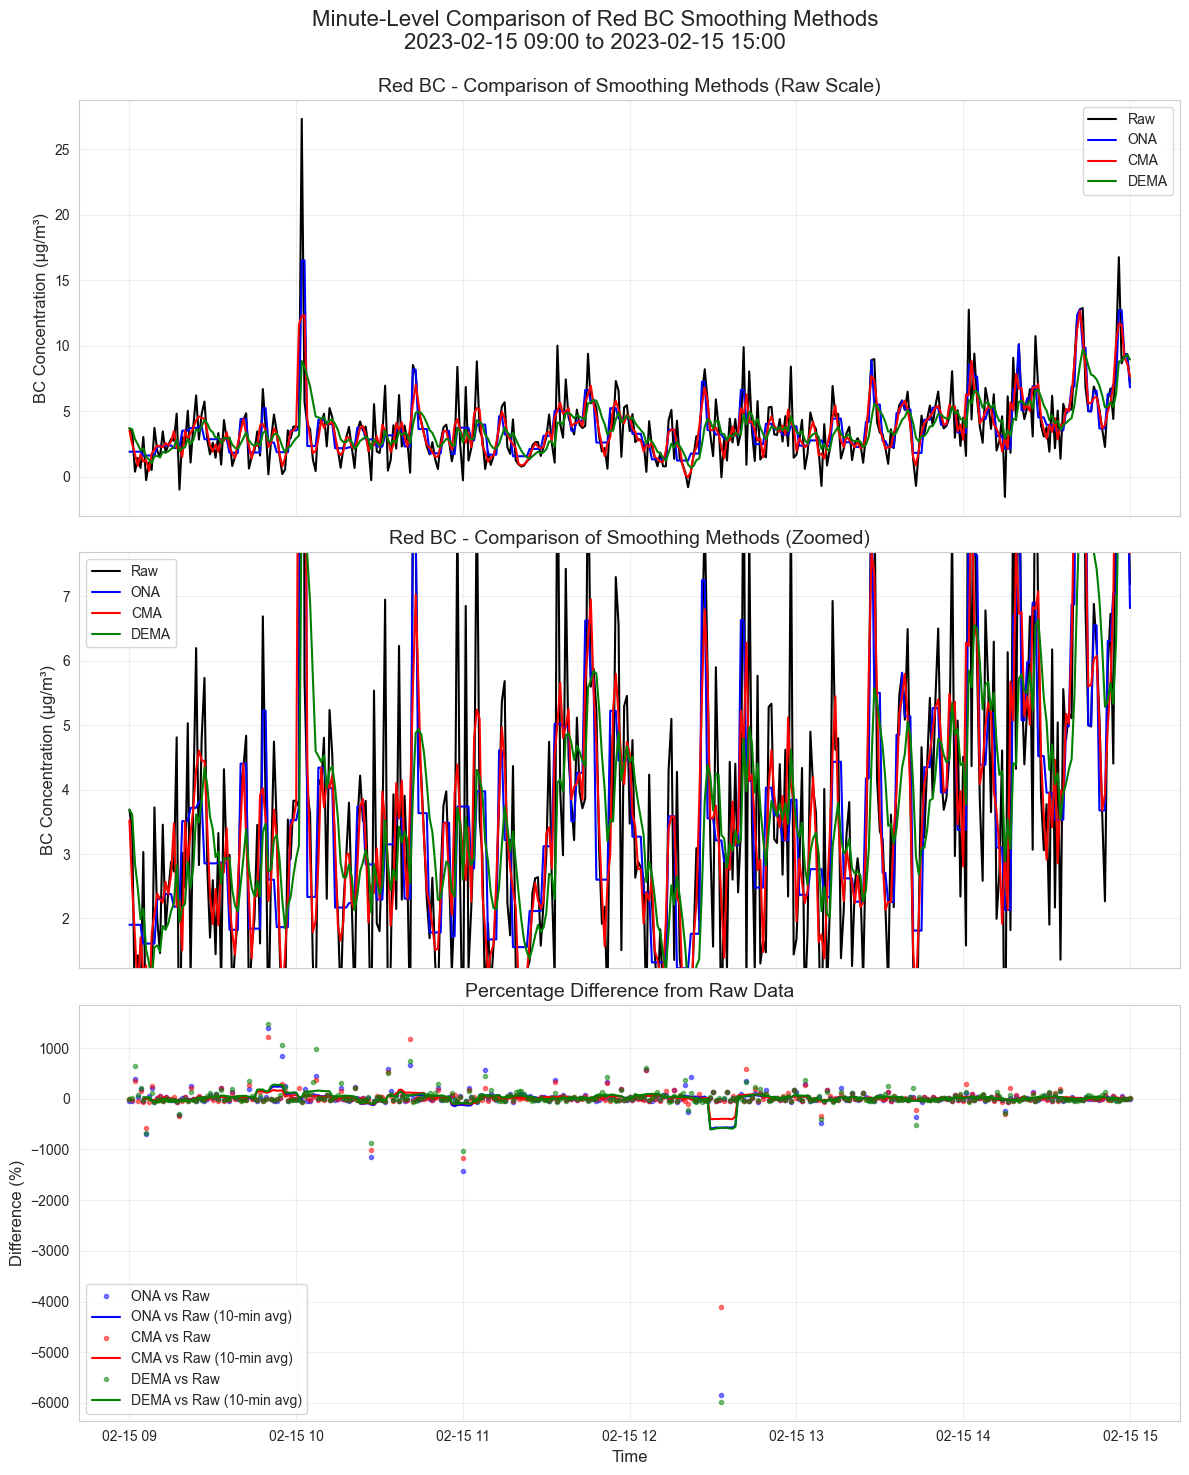


--- Adding Smoothed Data to Overlap DataFrame ---
Creating overlap DataFrame with all smoothing methods...
Input overlap_df_raw shape: (109, 15)

Statistics added for each smoothing method:
Raw (raw) - Mean BC range: 2.6 to 23.7
ONA (ona) - Mean BC range: 2.6 to 23.7
CMA (cma) - Mean BC range: 2.6 to 23.7
DEMA (dema) - Mean BC range: 2.6 to 23.7
Output overlap_df_all shape: (109, 57)
Column count: 57

Verifying differences between smoothing methods:

Method average BC values:
aeth_mean: 7.90 μg/m³
ona_mean: 7.90 μg/m³
cma_mean: 7.90 μg/m³
dema_mean: 7.90 μg/m³

Percentage differences from raw data:
ona_mean: -0.03%
cma_mean: -0.02%
dema_mean: -0.01%

Correlation matrix between methods:
           aeth_mean  ona_mean  cma_mean  dema_mean
aeth_mean      1.000     0.998     1.000      1.000
ona_mean       0.998     1.000     0.998      0.998
cma_mean       1.000     0.998     1.000      1.000
dema_mean      1.000     0.998     1.000      1.000

--- Creating Cross-Method Plots with All Sm

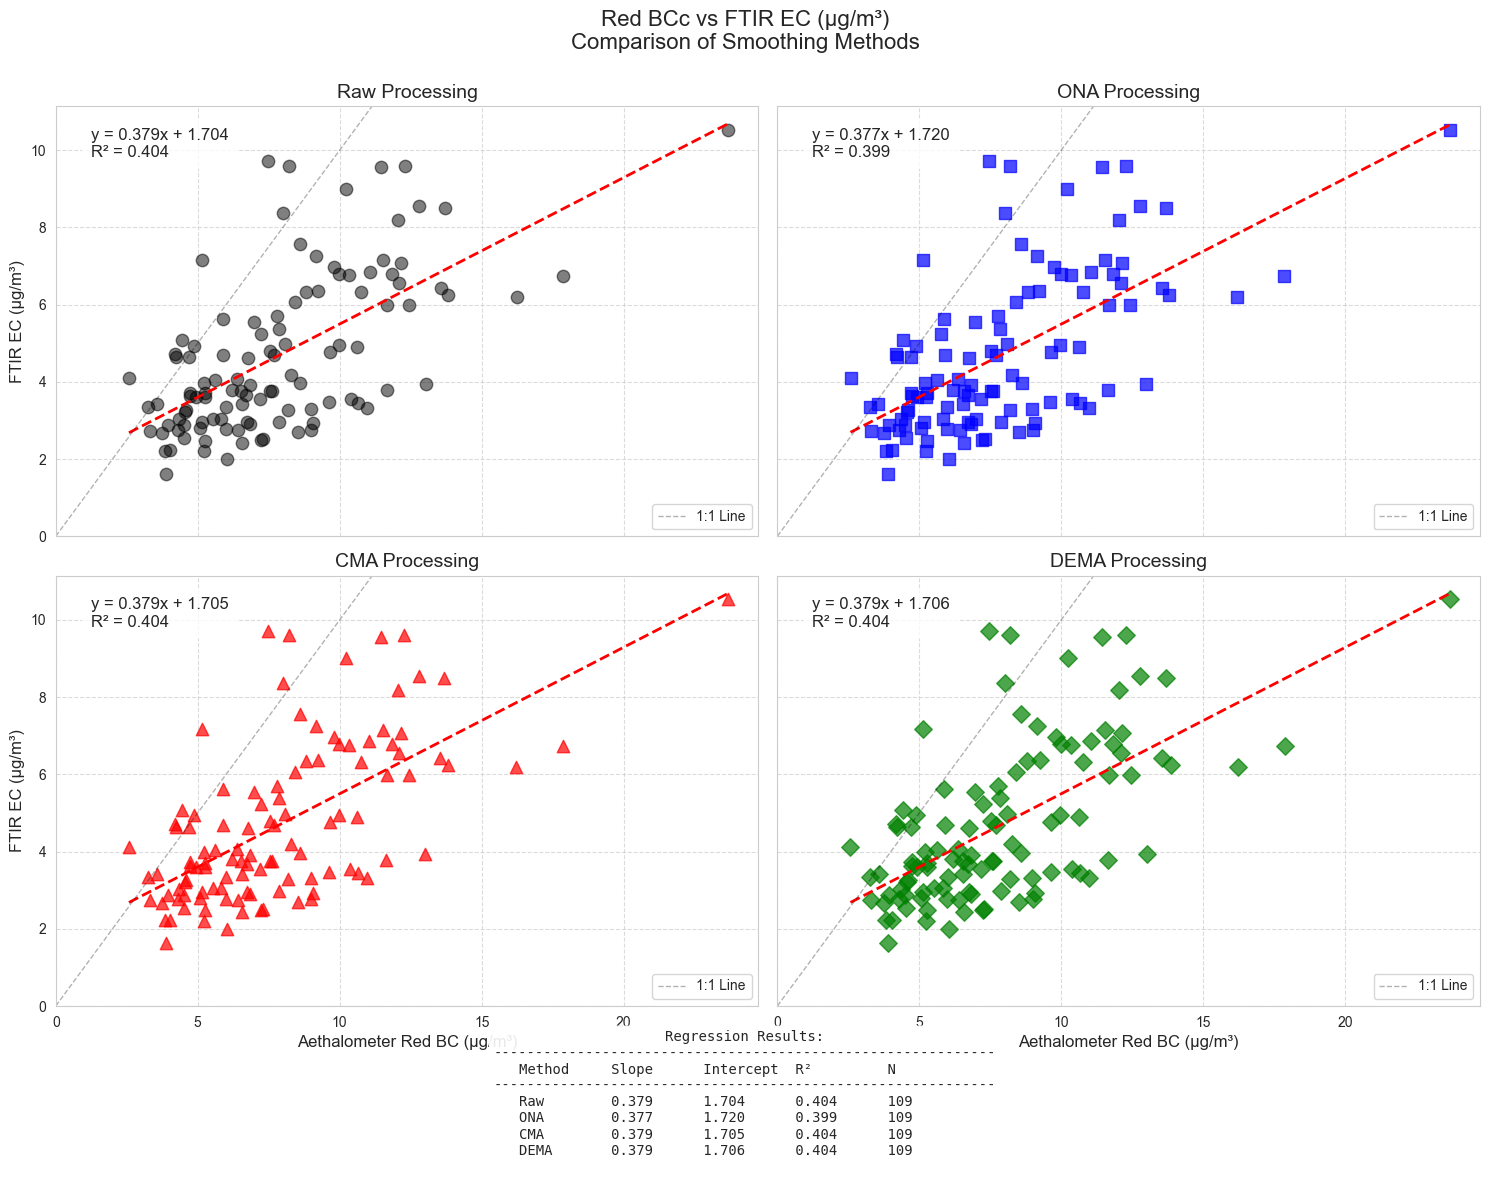

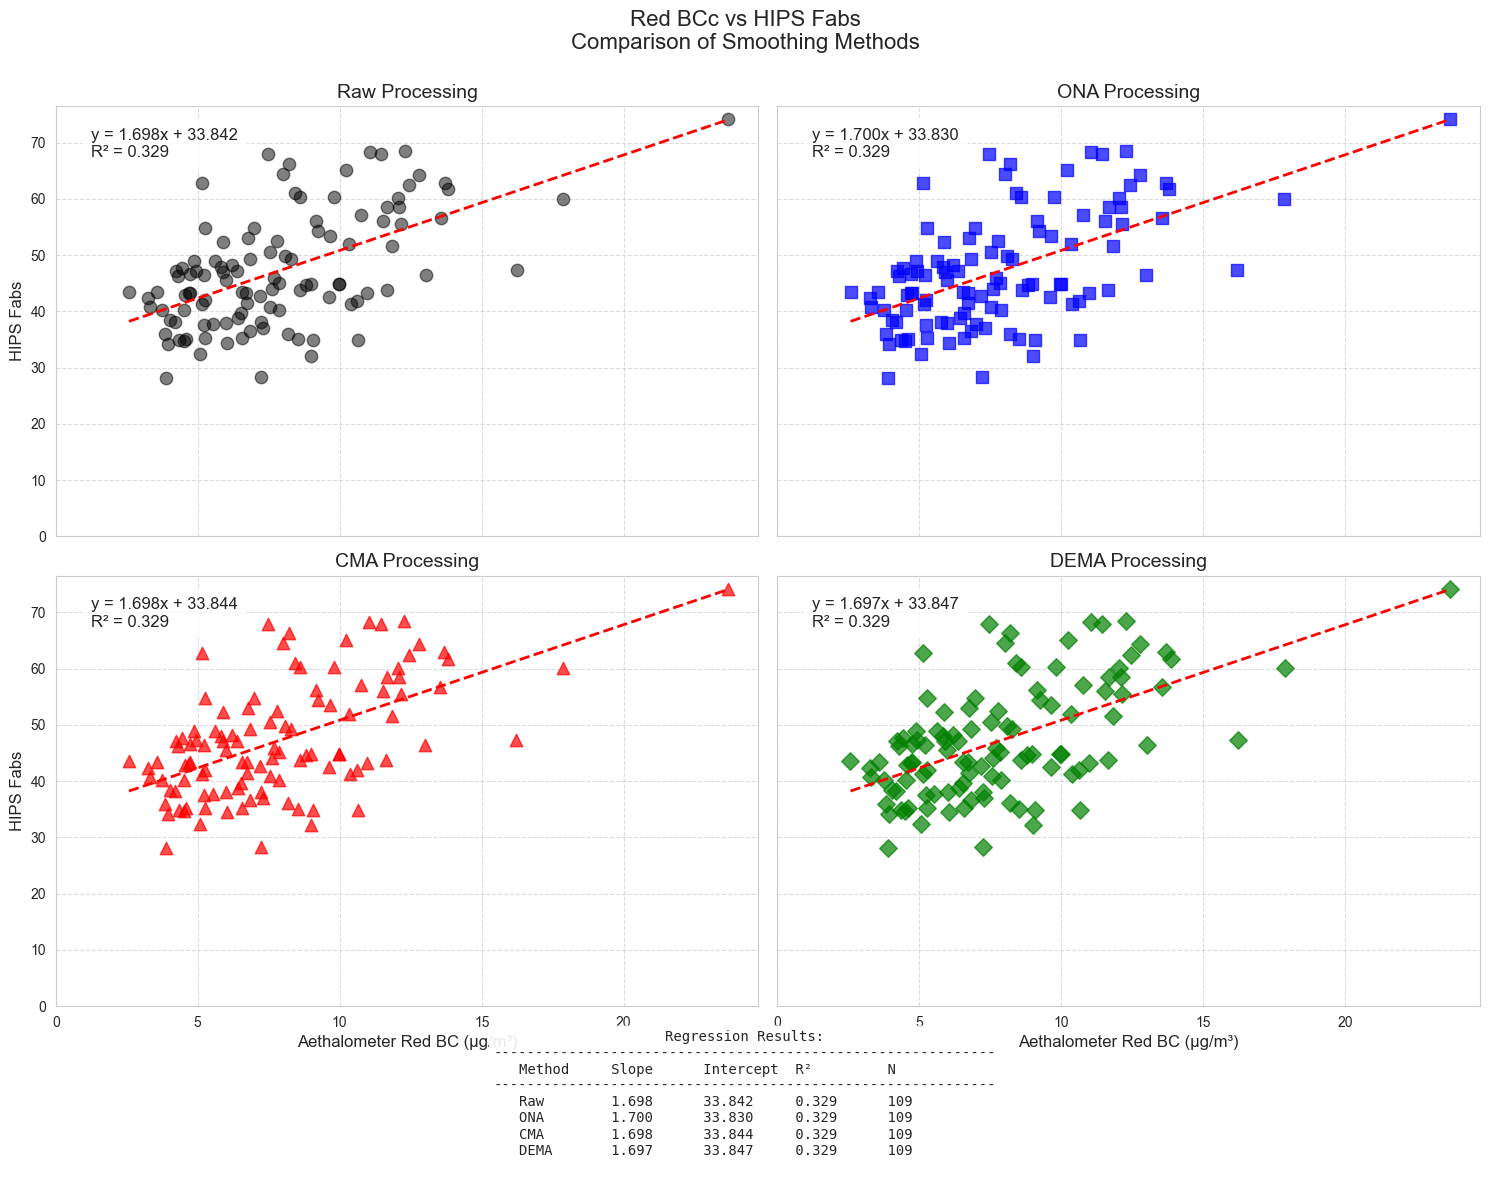


--- Calculating MAC Values For Each Method ---


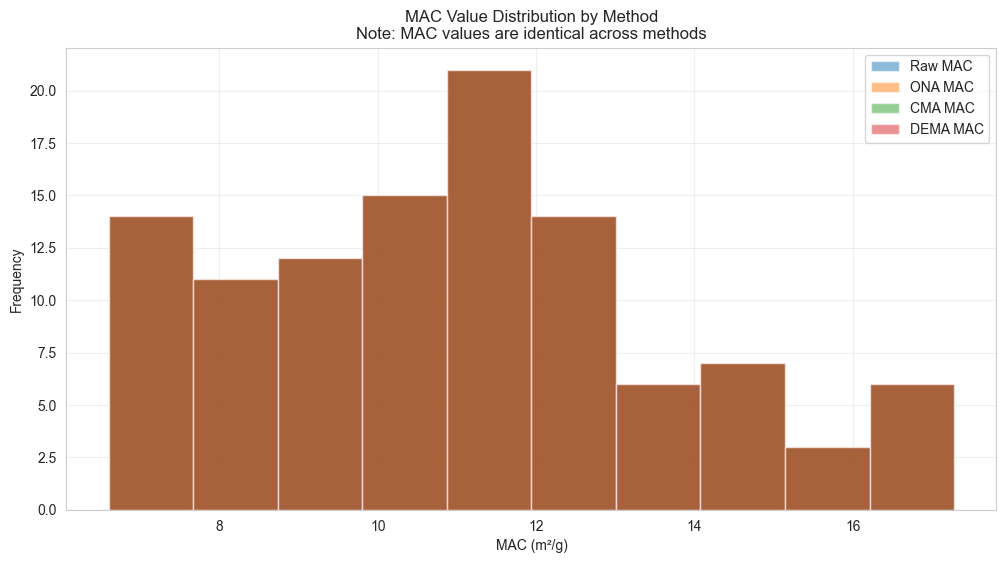


--- Saving Results ---

--- Analysis Complete ---
Successfully analyzed 109 overlapping excellent quality days with multiple smoothing methods


In [20]:
if __name__ == "__main__":
    results = main()

## Explore Results
 
After running the analysis, you can explore the results further. Here are some examples of additional analyses:


Explore the regression results in detail
Uncomment and run after executing the main function

In [21]:
if 'regression_summary' in results:
    reg_summary = results['regression_summary']
    
    print("\nReduced Ordinary Least Squares (OLS) Equations:")
    print("=" * 70)
    
    # FTIR EC comparison
    if 'FTIR_EC' in reg_summary:
        print("\nFTIR EC vs BC:")
        for method, stats in reg_summary['FTIR_EC'].items():
            print(f"{method}: EC = {stats['slope']:.3f} × BC + {stats['intercept']:.3f}  (R² = {stats['r_squared']:.3f}, n = {stats['data_points']})")
    
    # HIPS Fabs comparison
    if 'HIPS_Fabs' in reg_summary:
        print("\nHIPS Fabs vs BC:")
        for method, stats in reg_summary['HIPS_Fabs'].items():
            print(f"{method}: Fabs = {stats['slope']:.3f} × BC + {stats['intercept']:.3f}  (R² = {stats['r_squared']:.3f}, n = {stats['data_points']})")
    
    # MAC comparison
    if 'mac_comparison' in results:
        mac_comp = results['mac_comparison']
        
        print("\nMAC Values by Method and Season:")
        print("=" * 70)
        print(mac_comp.round(2).to_string(index=False))
        
        # Calculate method-to-method ratios for MAC values
        if len(mac_comp) > 1:
            print("\nMAC Ratios (Row Method / Column Method):")
            methods = mac_comp['Method'].tolist()
            ratio_matrix = np.zeros((len(methods), len(methods)))
            
            for i, method1 in enumerate(methods):
                for j, method2 in enumerate(methods):
                    if i != j:
                        mac1 = mac_comp.loc[mac_comp['Method'] == method1, 'Overall MAC'].values[0]
                        mac2 = mac_comp.loc[mac_comp['Method'] == method2, 'Overall MAC'].values[0]
                        ratio_matrix[i, j] = mac1 / mac2
            
            ratio_df = pd.DataFrame(ratio_matrix, index=methods, columns=methods)
            print(ratio_df.round(2))


Reduced Ordinary Least Squares (OLS) Equations:

FTIR EC vs BC:
Raw: EC = 0.379 × BC + 1.704  (R² = 0.404, n = 109)
ONA: EC = 0.377 × BC + 1.720  (R² = 0.399, n = 109)
CMA: EC = 0.379 × BC + 1.705  (R² = 0.404, n = 109)
DEMA: EC = 0.379 × BC + 1.706  (R² = 0.404, n = 109)

HIPS Fabs vs BC:
Raw: Fabs = 1.698 × BC + 33.842  (R² = 0.329, n = 109)
ONA: Fabs = 1.700 × BC + 33.830  (R² = 0.329, n = 109)
CMA: Fabs = 1.698 × BC + 33.844  (R² = 0.329, n = 109)
DEMA: Fabs = 1.697 × BC + 33.847  (R² = 0.329, n = 109)


Analyze the performance improvements by smoothing method
Uncomment and run after executing the main function


Improvement Metrics by Smoothing Method:
Method  Raw R² vs FTIR  Method R² vs FTIR  FTIR R² Improvement (%)  Raw R² vs HIPS  Method R² vs HIPS  HIPS R² Improvement (%)  Raw Negative Values (%)  Method Negative Values (%)  Negative Value Reduction (%)
   ONA             0.4                0.4                    -1.30            0.33               0.33                    -0.05                      0.0                         0.0                             0
   CMA             0.4                0.4                    -0.04            0.33               0.33                    -0.05                      0.0                         0.0                             0
  DEMA             0.4                0.4                    -0.08            0.33               0.33                    -0.04                      0.0                         0.0                             0


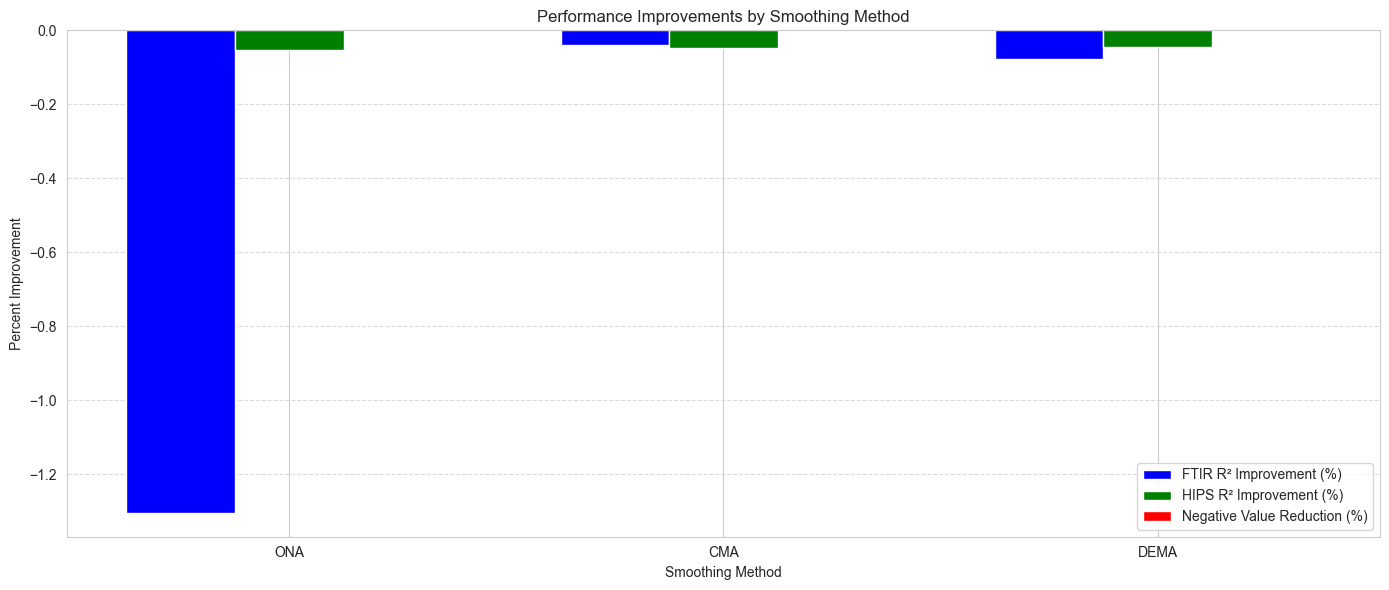

In [22]:
if 'overlap_df_all' in results:
    overlap_df = results['overlap_df_all']
    
    # Calculate improvement metrics
    methods = ['ona', 'cma', 'dema']
    improvement_metrics = []
    
    for method in methods:
        # Get column names
        raw_col = 'aeth_mean'
        method_col = f'{method}_mean'
        
        if raw_col in overlap_df.columns and method_col in overlap_df.columns:
            # Calculate metrics vs FTIR
            if 'EC_FTIR' in overlap_df.columns:
                # Convert to μg/m³
                raw_vs_ftir = pearsonr(overlap_df[raw_col], overlap_df['EC_FTIR'])[0]**2
                method_vs_ftir = pearsonr(overlap_df[method_col], overlap_df['EC_FTIR'])[0]**2
                ftir_improvement = (method_vs_ftir - raw_vs_ftir) / raw_vs_ftir * 100
            else:
                raw_vs_ftir = np.nan
                method_vs_ftir = np.nan
                ftir_improvement = np.nan
            
            # Calculate metrics vs HIPS
            if 'Fabs' in overlap_df.columns:
                raw_vs_hips = pearsonr(overlap_df[raw_col], overlap_df['Fabs'])[0]**2
                method_vs_hips = pearsonr(overlap_df[method_col], overlap_df['Fabs'])[0]**2
                hips_improvement = (method_vs_hips - raw_vs_hips) / raw_vs_hips * 100
            else:
                raw_vs_hips = np.nan
                method_vs_hips = np.nan
                hips_improvement = np.nan
            
            # Calculate negative value reduction
            raw_neg_pct = (overlap_df[raw_col] < 0).mean() * 100
            method_neg_pct = (overlap_df[method_col] < 0).mean() * 100
            neg_reduction = (raw_neg_pct - method_neg_pct) / raw_neg_pct * 100 if raw_neg_pct > 0 else 0
            
            # Add to metrics
            improvement_metrics.append({
                'Method': method.upper(),
                'Raw R² vs FTIR': raw_vs_ftir,
                'Method R² vs FTIR': method_vs_ftir,
                'FTIR R² Improvement (%)': ftir_improvement,
                'Raw R² vs HIPS': raw_vs_hips,
                'Method R² vs HIPS': method_vs_hips,
                'HIPS R² Improvement (%)': hips_improvement,
                'Raw Negative Values (%)': raw_neg_pct,
                'Method Negative Values (%)': method_neg_pct,
                'Negative Value Reduction (%)': neg_reduction
            })
    
    # Create DataFrame and display
    if improvement_metrics:
        improvement_df = pd.DataFrame(improvement_metrics)
        print("\nImprovement Metrics by Smoothing Method:")
        print("=" * 100)
        print(improvement_df.round(2).to_string(index=False))
        
        # Create bar plot of improvements
        plt.figure(figsize=(14, 6))
        
        # Prepare data for plotting
        methods = improvement_df['Method']
        ftir_improvement = improvement_df['FTIR R² Improvement (%)']
        hips_improvement = improvement_df['HIPS R² Improvement (%)']
        neg_reduction = improvement_df['Negative Value Reduction (%)']
        
        # Set up bar positions
        x = np.arange(len(methods))
        width = 0.25
        
        # Create bars
        plt.bar(x - width, ftir_improvement, width, label='FTIR R² Improvement (%)', color='blue')
        plt.bar(x, hips_improvement, width, label='HIPS R² Improvement (%)', color='green')
        plt.bar(x + width, neg_reduction, width, label='Negative Value Reduction (%)', color='red')
        
        # Add labels and formatting
        plt.xlabel('Smoothing Method')
        plt.ylabel('Percent Improvement')
        plt.title('Performance Improvements by Smoothing Method')
        plt.xticks(x, methods)
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.show()

In [23]:
# After running the main function
if 'overlap_df_all' in results:
    print("\n--- Summary of Raw and Smoothed Values ---")
    overlap_df_all = results['overlap_df_all']
    
    # Create a simple summary table
    summary_df = overlap_df_all[['EC_FTIR', 'Fabs', 'aeth_mean', 'ona_mean', 'cma_mean', 'dema_mean']].copy()
    
    # Calculate summary statistics
    summary_stats = summary_df.describe().round(2)
    print(summary_stats)
    
    # Show first 5 rows as examples
    print("\nSample data (first 5 days):")
    print(summary_df.head().round(2))
    
    # Calculate percentage differences from raw data
    print("\nPercentage differences from raw data:")
    for method in ['ona_mean', 'cma_mean', 'dema_mean']:
        pct_diff = ((summary_df[method] - summary_df['aeth_mean']) / summary_df['aeth_mean'] * 100).mean()
        print(f"{method}: {pct_diff:.4f}%")


--- Summary of Raw and Smoothed Values ---
       EC_FTIR    Fabs  aeth_mean  ona_mean  cma_mean  dema_mean
count   109.00  109.00     109.00    109.00    109.00     109.00
mean      4.70   47.25       7.90      7.90      7.90       7.90
std       2.04   10.12       3.42      3.41      3.42       3.42
min       1.63   28.09       2.58      2.58      2.58       2.58
25%       3.05   40.24       5.23      5.23      5.23       5.22
50%       3.97   45.10       7.29      7.31      7.29       7.29
75%       6.19   54.35       9.97      9.97      9.97       9.97
max      10.53   74.19      23.69     23.69     23.69      23.69

Sample data (first 5 days):
   EC_FTIR   Fabs  aeth_mean  ona_mean  cma_mean  dema_mean
0     3.71  54.75       5.26      5.26      5.26       5.26
1     8.19  60.17      12.05     12.05     12.05      12.05
2     3.35  37.96       5.99      5.99      6.00       6.00
3     4.94  48.87       4.87      4.87      4.87       4.87
4     6.85  68.28      11.05     11.05    

In [28]:
def plot_method_detail_comparison(smoothed_data, wavelength="Red", sample_period=None):
    """Create detailed side-by-side comparison of each smoothing method vs raw data"""
    # Extract column names
    raw_col = f"{wavelength} BCc"
    ona_col = f"{wavelength}_BC_ONA"
    cma_col = f"{wavelength}_BC_CMA"
    dema_col = f"{wavelength}_BC_DEMA"
    
    # Prepare the data
    raw_df = smoothed_data['raw'] 
    ona_df = smoothed_data['ona']
    cma_df = smoothed_data['cma']
    dema_df = smoothed_data['dema']
    
    # If sample_period is not provided, use a default period
    if sample_period is None:
        # Find a 6-hour period with good data
        start = raw_df.index[0]
        end = start + pd.Timedelta(hours=6)
    else:
        start, end = sample_period
    
    # Create a figure with 3 subplots (one for each smoothing method)
    fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    
    methods = [('ONA', ona_df, ona_col, 'b-'), 
               ('CMA', cma_df, cma_col, 'r-'), 
               ('DEMA', dema_df, dema_col, 'g-')]
    
    # Use a safer approach to get data between two timestamps
    # This avoids issues with exact timestamp matching
    raw_data = raw_df[(raw_df.index >= start) & (raw_df.index <= end)][raw_col]
    
    if len(raw_data) == 0:
        print(f"No raw data found between {start} and {end}")
        plt.close(fig)
        return None
    
    # Plot each method with raw data side by side
    for i, (method_name, df, col, style) in enumerate(methods):
        if col not in df.columns:
            print(f"Column {col} not found in {method_name} data")
            continue
            
        # Get data safely
        method_data = df[(df.index >= start) & (df.index <= end)][col]
        
        if len(method_data) == 0:
            print(f"No {method_name} data found between {start} and {end}")
            continue
        
        # Plot raw and method data
        axes[i].plot(raw_data.index, raw_data, 'k-', alpha=0.5, label='Raw')
        axes[i].plot(method_data.index, method_data, style, label=method_name)
        
        # Add basic statistics in a text box (safely handle empty data)
        if len(method_data) > 0 and len(raw_data) > 0:
            mean_diff = method_data.mean() - raw_data.mean()
            std_reduction = 0
            if raw_data.std() > 0:
                std_reduction = 100 * (1 - method_data.std() / raw_data.std())
                
            stats_text = (f"Mean difference: {mean_diff:.2f} μg/m³\n"
                         f"Std reduction: {std_reduction:.1f}%")
            
            axes[i].text(0.02, 0.95, stats_text, transform=axes[i].transAxes, 
                        bbox=dict(facecolor='white', alpha=0.8))
        
        axes[i].set_title(f"{method_name} vs Raw {wavelength} BC")
        axes[i].set_ylabel("BC Concentration (μg/m³)")
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    # Add overall title and x-label
    period_str = f"{start.strftime('%Y-%m-%d %H:%M')} to {end.strftime('%Y-%m-%d %H:%M')}"
    plt.suptitle(f"Detailed Method Comparison - {wavelength} BC\n{period_str}", fontsize=16)
    axes[2].set_xlabel("Time")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    
    return fig

def find_interesting_window(data, column, window_hours=1):
    """Find a window with interesting data (high variance or extremes)"""
    if column not in data.columns:
        print(f"Column {column} not found in data")
        return data.index[0], data.index[min(10, len(data)-1)]
        
    # Calculate rolling variance
    window_size = int(window_hours * 60)  # 60 minutes per hour
    rolling_var = data[column].rolling(window=window_size).var()
    
    # Find window with highest variance
    max_var_idx = rolling_var.idxmax()
    if pd.isnull(max_var_idx):
        # Fallback to the beginning of the data
        return data.index[0], data.index[min(window_size, len(data)-1)]
    
    start_time = max_var_idx - pd.Timedelta(minutes=window_size//2)
    end_time = max_var_idx + pd.Timedelta(minutes=window_size//2)
    
    # Ensure within data bounds
    if start_time < data.index[0]:
        start_time = data.index[0]
    if end_time > data.index[-1]:
        end_time = data.index[-1]
        
    return start_time, end_time

def plot_smoothing_method_summary(smoothed_data, wavelength="Red", sample_period=None):
    """Create a statistical summary comparing methods"""
    # Extract column names
    raw_col = f"{wavelength} BCc"
    ona_col = f"{wavelength}_BC_ONA"
    cma_col = f"{wavelength}_BC_CMA"
    dema_col = f"{wavelength}_BC_DEMA"
    
    # Prepare the data
    raw_df = smoothed_data['raw'] 
    ona_df = smoothed_data['ona']
    cma_df = smoothed_data['cma']
    dema_df = smoothed_data['dema']
    
    # If sample_period is not provided, use a default period
    if sample_period is None:
        # Find a 6-hour period with good data
        start = raw_df.index[0]
        end = start + pd.Timedelta(hours=6)
    else:
        start, end = sample_period
    
    # Create figure with statistical comparisons
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # First subplot: Box plot comparison
    method_data = []
    method_names = []
    
    if raw_col in raw_df.columns:
        raw_slice = raw_df[(raw_df.index >= start) & (raw_df.index <= end)][raw_col]
        if len(raw_slice) > 0:
            method_data.append(raw_slice)
            method_names.append('Raw')
    
    if ona_col in ona_df.columns:
        ona_slice = ona_df[(ona_df.index >= start) & (ona_df.index <= end)][ona_col]
        if len(ona_slice) > 0:
            method_data.append(ona_slice)
            method_names.append('ONA')
    
    if cma_col in cma_df.columns:
        cma_slice = cma_df[(cma_df.index >= start) & (cma_df.index <= end)][cma_col]
        if len(cma_slice) > 0:
            method_data.append(cma_slice)
            method_names.append('CMA')
    
    if dema_col in dema_df.columns:
        dema_slice = dema_df[(dema_df.index >= start) & (dema_df.index <= end)][dema_col]
        if len(dema_slice) > 0:
            method_data.append(dema_slice)
            method_names.append('DEMA')
    
    if not method_data:
        print(f"No data found between {start} and {end}")
        plt.close(fig)
        return None
    
    # First subplot: Box plot
    axes[0, 0].boxplot(method_data, labels=method_names)
    axes[0, 0].set_title('Distribution of BC Values')
    axes[0, 0].set_ylabel('BC Concentration (μg/m³)')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Second subplot: Bar chart of standard deviations
    std_values = [data.std() for data in method_data]
    axes[0, 1].bar(method_names, std_values)
    axes[0, 1].set_title('Standard Deviation by Method')
    axes[0, 1].set_ylabel('Standard Deviation (μg/m³)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Third subplot: Line plot of moving averages
    window = 10  # 10-minute moving average
    for i, data in enumerate(method_data):
        ma = data.rolling(window=window, center=True).mean()
        axes[1, 0].plot(ma.index, ma, label=method_names[i])
    
    axes[1, 0].set_title(f'{window}-Minute Moving Average')
    axes[1, 0].set_ylabel('BC Concentration (μg/m³)')
    axes[1, 0].set_xlabel('Time')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Fourth subplot: Histogram of percentage differences
    if 'Raw' in method_names:
        raw_idx = method_names.index('Raw')
        raw_data = method_data[raw_idx]
        
        for i, (data, name) in enumerate(zip(method_data, method_names)):
            if name != 'Raw':
                # Use only points where both datasets have values
                common_idx = data.index.intersection(raw_data.index)
                if len(common_idx) > 0:
                    data_aligned = data.loc[common_idx]
                    raw_aligned = raw_data.loc[common_idx]
                    
                    # Calculate percentage difference where raw data isn't too close to zero
                    valid_mask = np.abs(raw_aligned) > 0.1  # Avoid division by very small numbers
                    if valid_mask.any():
                        diff_pct = ((data_aligned[valid_mask] - raw_aligned[valid_mask]) / 
                                    raw_aligned[valid_mask] * 100)
                        
                        # Clip to reasonable range for visualization
                        diff_pct_clipped = np.clip(diff_pct, -100, 100)
                        axes[1, 1].hist(diff_pct_clipped, bins=20, alpha=0.5, label=name)
    
    axes[1, 1].set_title('Histogram of % Differences from Raw')
    axes[1, 1].set_xlabel('Percentage Difference (%)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add overall title
    period_str = f"{start.strftime('%Y-%m-%d %H:%M')} to {end.strftime('%Y-%m-%d %H:%M')}"
    plt.suptitle(f"Statistical Summary - {wavelength} BC\n{period_str}", fontsize=16)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    
    return fig


--- Creating visualizations for period: 2023-02-15 09:00:00 to 2023-02-15 15:00:00 ---
Generating method detail comparison...


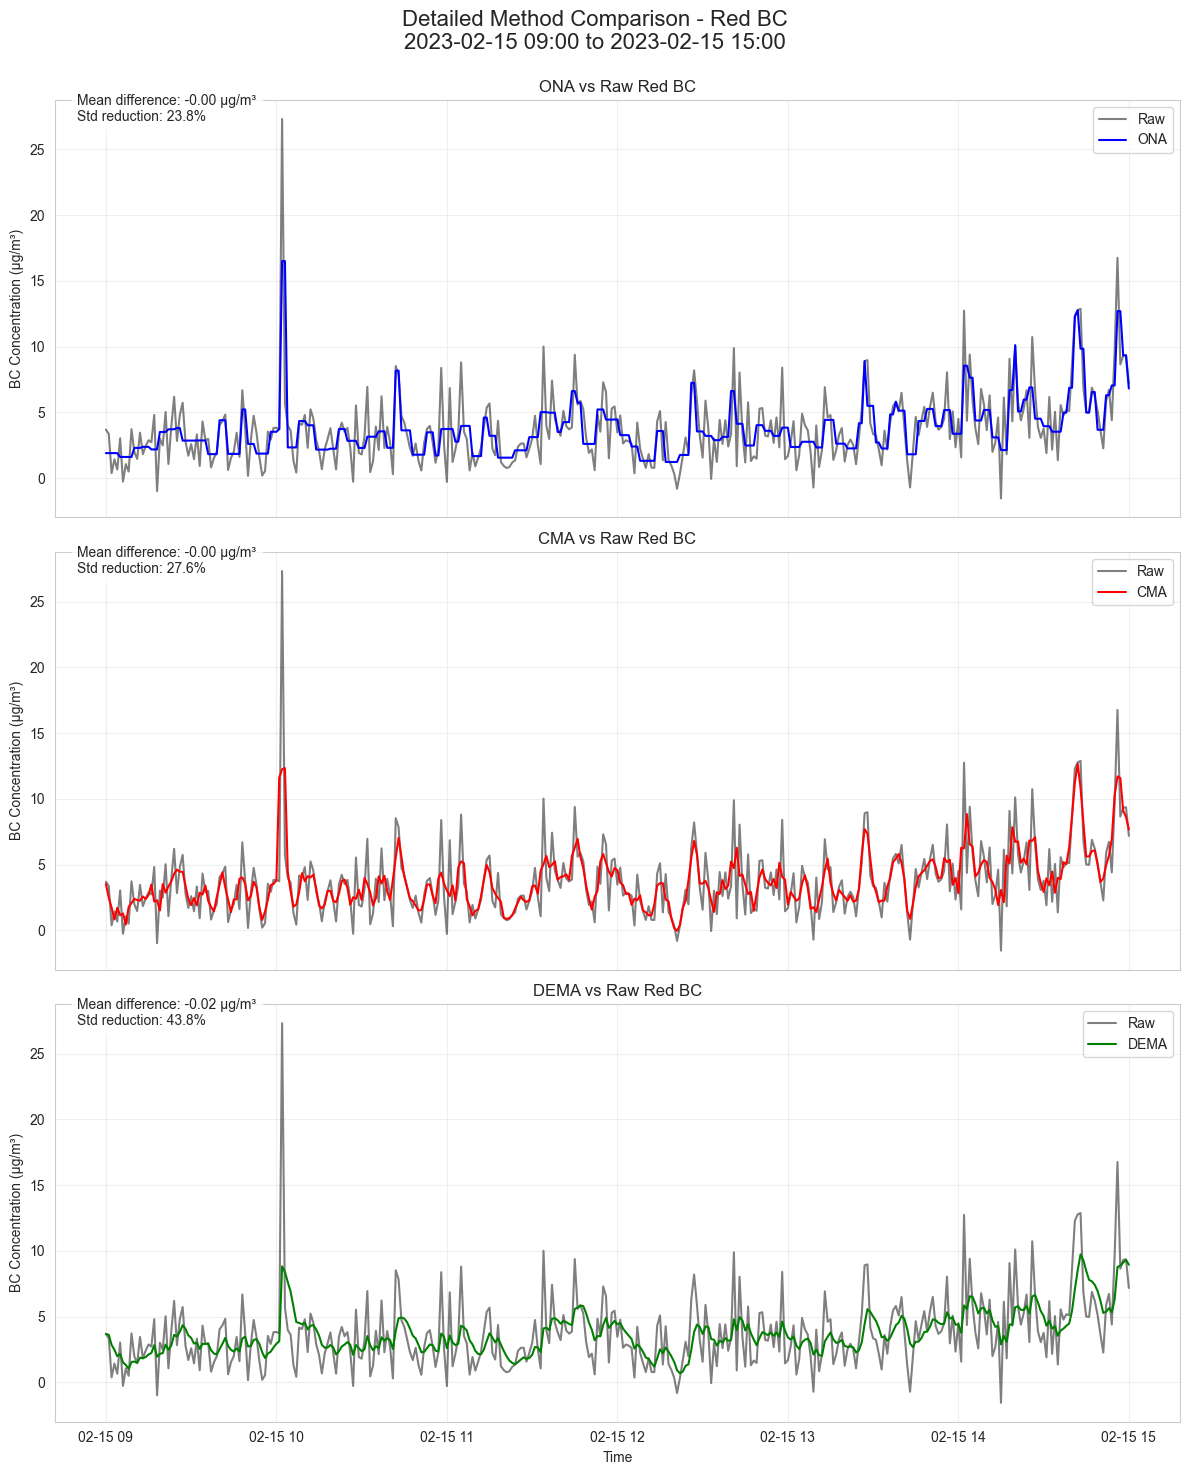

Finding an interesting time window...
Found interesting period: 2024-03-01 08:08:00 to 2024-03-01 09:08:00
Generating focused method detail comparison...


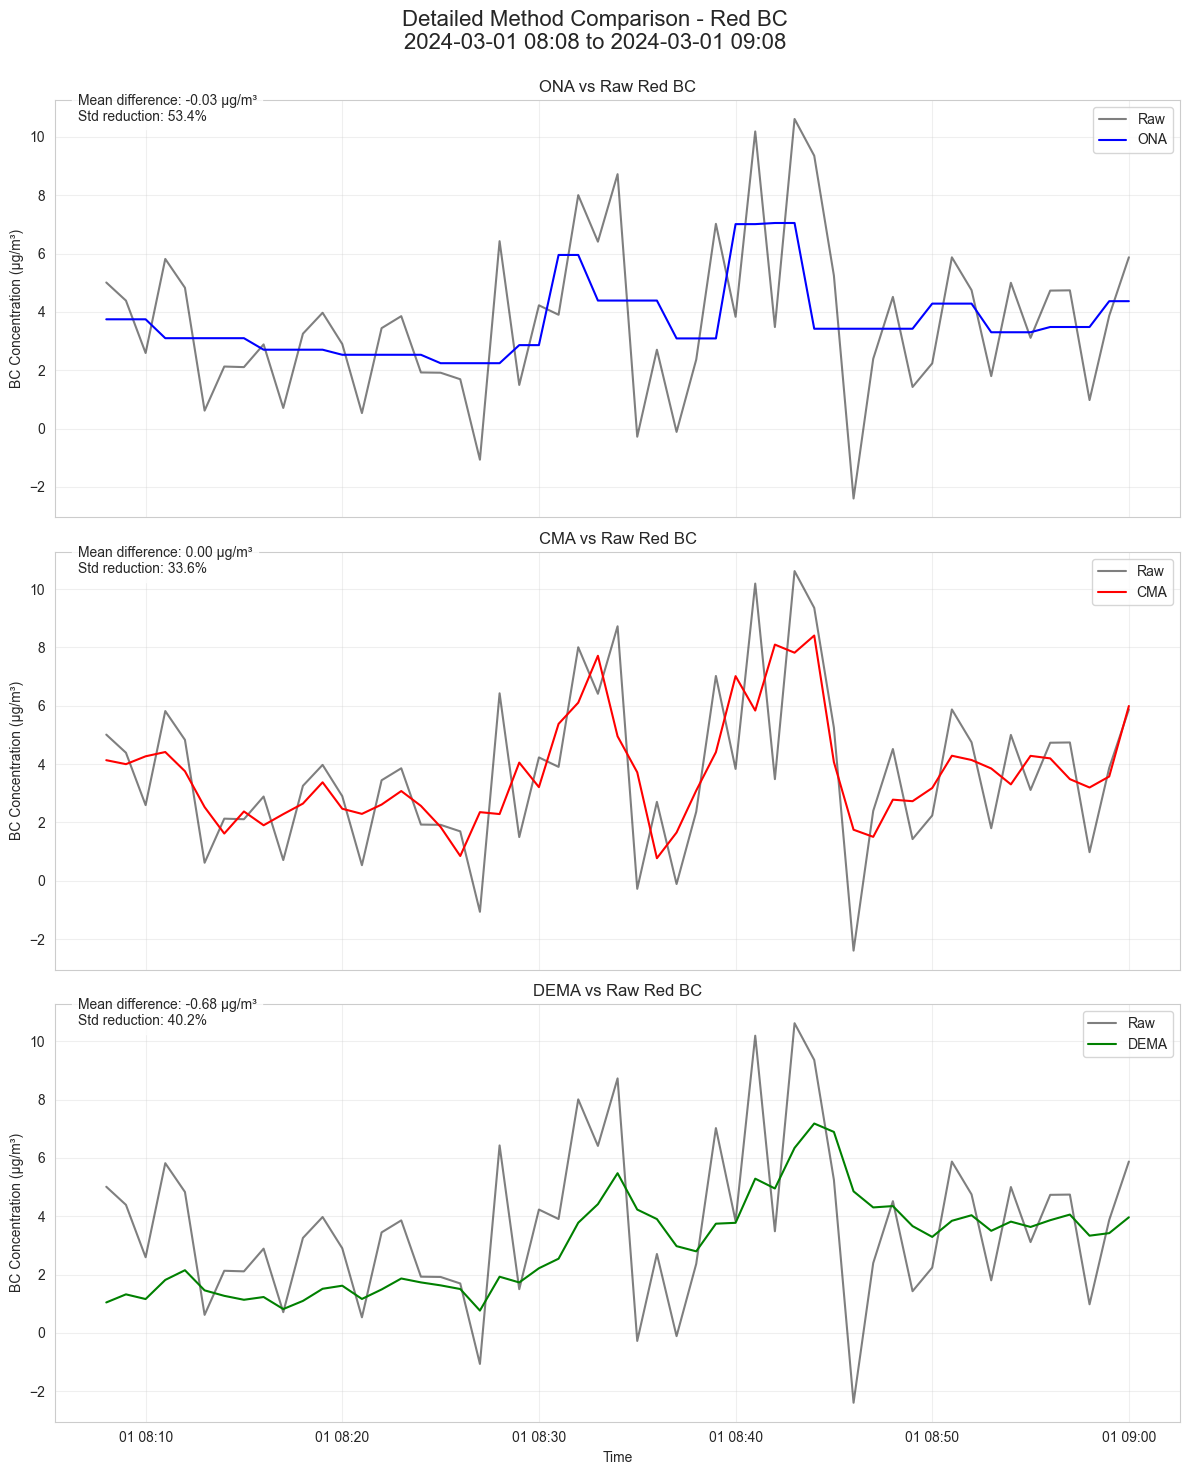

Generating statistical summary...


/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_42191/248989577.py:170: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 0].boxplot(method_data, labels=method_names)


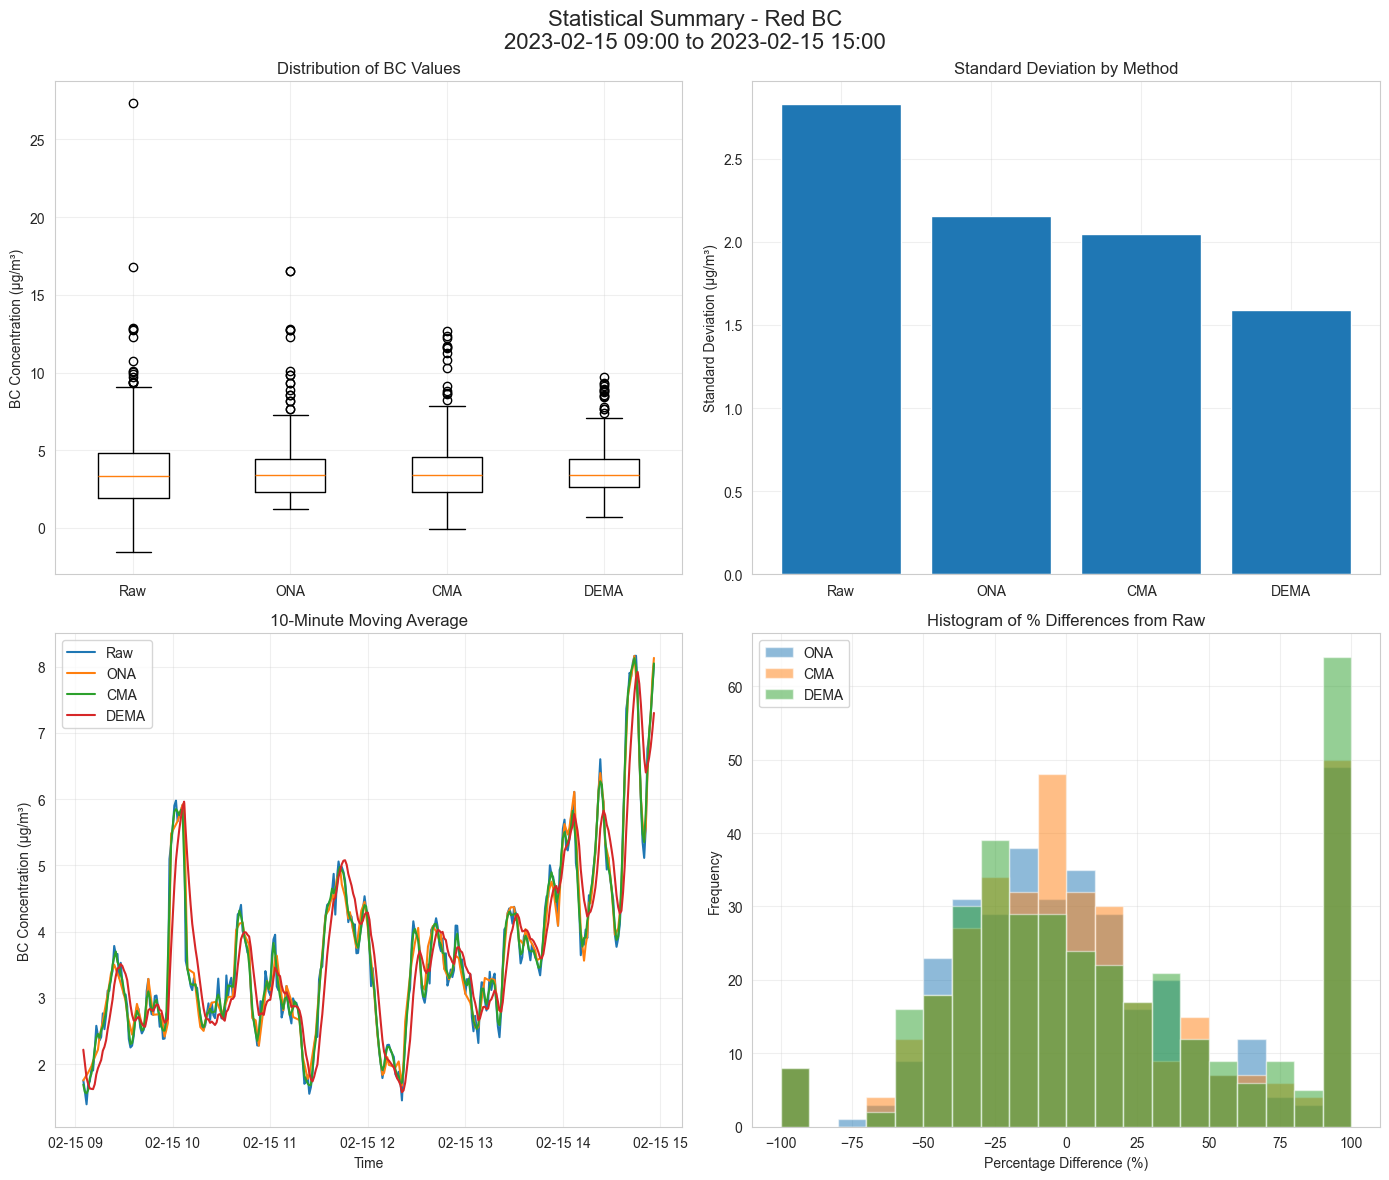

In [29]:
# %% [markdown]
# ## Additional Visualizations
# These visualizations provide more detailed insights into the smoothing methods.

# %%
# Make sure to add this at the top of your notebook if not already there
%matplotlib inline

# %%
if 'smoothed_data' in results and 'aethalometer_df' in results:
    # Use the filtered data directly for visualization
    filtered_data = results['smoothed_data']['raw']
    
    # Choose a reasonable time window - 6 hours from start of data
    try:
        start_time = filtered_data.index[0]
        end_time = start_time + pd.Timedelta(hours=6)
        
        # Make sure end_time exists in the dataset
        if end_time > filtered_data.index[-1]:
            end_time = filtered_data.index[-1]
            
        print(f"\n--- Creating visualizations for period: {start_time} to {end_time} ---")
        
        # 1. Create a detailed side-by-side comparison
        print("Generating method detail comparison...")
        fig_detail = plot_method_detail_comparison(results['smoothed_data'], 
                                                  wavelength="Red", 
                                                  sample_period=(start_time, end_time))
        if fig_detail is not None:
            plt.show()
        
        # 2. Find a more focused period with interesting patterns
        print("Finding an interesting time window...")
        raw_col = "Red BCc"
        try:
            interesting_start, interesting_end = find_interesting_window(filtered_data, 
                                                                      raw_col, 
                                                                      window_hours=1)
            
            print(f"Found interesting period: {interesting_start} to {interesting_end}")
            
            # 3. Create detailed comparison for the interesting period
            print("Generating focused method detail comparison...")
            fig_detail_focused = plot_method_detail_comparison(results['smoothed_data'], 
                                                            wavelength="Red", 
                                                            sample_period=(interesting_start, interesting_end))
            if fig_detail_focused is not None:
                plt.show()
        except Exception as e:
            print(f"Error finding interesting window: {e}")
        
        # 4. Create statistical summary visualization
        print("Generating statistical summary...")
        fig_summary = plot_smoothing_method_summary(results['smoothed_data'], 
                                                  wavelength="Red", 
                                                  sample_period=(start_time, end_time))
        if fig_summary is not None:
            plt.show()
    
    except Exception as e:
        print(f"Error creating visualizations: {e}")